<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [1]:
%%capture
pip install pyswarms

In [7]:
%%capture
pip install scipy

In [8]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 20000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 4000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_quarto_cenario'
NOME_ARQUIVO_CICLO_TEMPO_SEVERIDADE = 'ciclo_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '04'

In [ ]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [ ]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [ ]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [ ]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [ ]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [ ]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [ ]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [ ]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [ ]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [ ]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [ ]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [ ]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-10-29 18:59:59,696 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0843
2023-10-29 18:59:59,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0842717423313231, best pos: [148.94461573   1.00112862   0.85841885]


In [ ]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.9446157275814
beta: 1.0011286172507008
theta: 0.8584188455022862

Tempo de Convergência para a primeira etapa: 0.006781339645385742 segundos


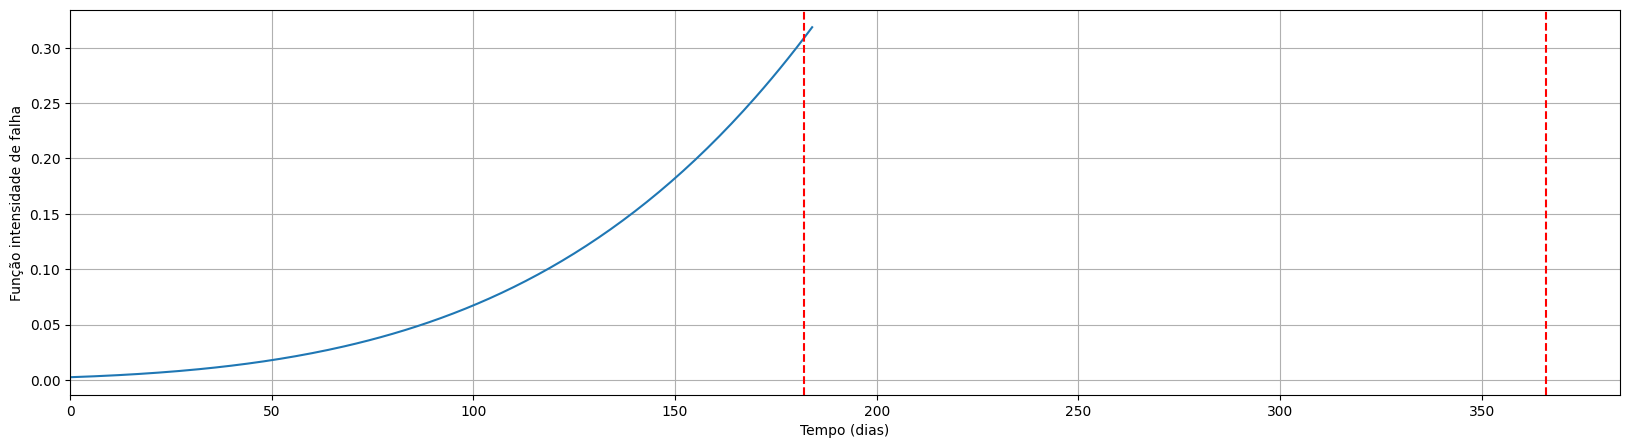

Fator ajuste:  [0.5761683038105456, 0.5761683038105456, 0.5761683038105456, 0.5761683038105456, 0.5761683038105456, 0.3489764242445176, 0.3489764242445176, 0.5761683038105456, 0.3489764242445176, 0.5761683038105456, 0.3489764242445176, 0.5761683038105456, 0.5761683038105456, 0.5761683038105456]


In [ ]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [ ]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [ ]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-29 19:00:01,245 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=6.78e+4<ipython-input-20-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=6.78e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 58, 126, 166, 237, 377, 488, 574, 610, 650, 679]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014]
Media de falhas:  [0, 0.008906447989340571, 0.10132939882481835, 0.26789746812850823, 1.5514688538345105, 30.58857538416083, 164.19603776795785, 213.4969632815521, 346.4836600066151, 536.3537090260625, 704.9079221032378, 1085.6528570371684]
Custo =  357294.0876829202


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 5, 229, 378, 397, 423, 514, 548, 580, 619, 658]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.5761

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=6.78e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 24, 33, 146, 208, 223, 248, 285, 379, 401, 559, 579, 636, 678]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014]
Media de falhas:  [0, 0.00010751232448201807, 0.00014097791034438205, 0.5998359999066182, 1.7980006961260178, 2.227542736855279, 3.2964711683919465, 6.005221685302046, 26.371400697111486, 33.04562137695441, 120.7257633321062, 182.88133222422377, 289.70550557657793, 525.6206504368267, 913.0619670239593]
Custo =  291550.12452540395


Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 13, 33, 111, 221, 256, 287, 

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=6.78e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 85, 159, 194, 228, 311, 400, 433, 488, 517, 553]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.06033869291044219, 0.27910330059040833, 0.81257185790406, 1.8190379718673049, 17.500939810700988, 41.657040721904, 47.67741530921082, 124.65427887417889, 148.97369231086105, 188.22530780070485, 719.0061596211965]
Custo =  106187.0145904521


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 1, 94, 154, 198, 228, 365, 446, 496, 526, 557, 596, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.57

pyswarms.single.global_best:  59%|█████▉    |59/100, best_cost=4.48e+4

Custo =  127372.70629352174


Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 3, 102, 134, 179, 191, 233, 359, 364, 408, 430, 551, 656, 707]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865]
Media de falhas:  [0, 3.2427398006144896e-09, 0.1379728615924346, 0.19440859655338183, 0.6769444993617288, 0.8623570251082862, 2.1958463357520634, 23.704515753157647, 24.77057585654591, 55.0345394350435, 58.93410399953341, 298.1147345596206, 511.0684667616, 659.0260110415238, 840.6976801517075]
Custo =  249226.19594642904


Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 22, 64

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=4.48e+4



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 98, 188, 325, 375, 396, 431, 472, 558, 578]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.12302133369905566, 0.6581146473215457, 16.35408876607828, 27.319017484447762, 33.386567604972775, 39.657404063701854, 91.73299842829238, 135.82174466014607, 147.4215451411658, 609.3512284343122]
Custo =  94409.35998534097


Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 19, 103, 293, 304, 384, 405, 440, 483, 559]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.19313968014563

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=4.48e+4



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 94, 140, 204, 304, 370, 398, 478, 531, 560]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.09985899494859796, 0.16188372479547225, 1.3027438189692686, 6.32463232129829, 34.21638112359447, 42.359052329238224, 64.53572679302482, 170.47073665370317, 185.27939078342135, 696.8241490728236]
Custo =  99708.54743915846


Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 29, 76, 94, 129, 163, 303, 348, 374, 400, 528, 560, 679, 713]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.48e+4
2023-10-29 19:00:02,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27899846 1.97052333 5.9818479  3.03359304 6.81932797 6.24269304
 3.0554745  5.24981636 2.56120943 1.8982521  2.80090234 4.60225851
 4.65555726 2.55060104 1.81824611 6.58444356 3.23061017 3.26107672
 3.78611765 6.61543603 0.38761767 4.03066656 6.3929347  3.132748  ]
2023-10-29 19:00:02,690 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 97, 156, 343, 369, 476, 533, 558, 587, 635, 668]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.1168647643347678, 0.25214978176987624, 27.500302076675272, 29.998695779011562, 88.24164863158606, 112.24693559913109, 124.83286809045188, 165.49705923222433, 255.82421786983275, 289.9770346275914, 492.5006300895019]
Custo =  141247.9947301489


Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 10, 55, 68, 96, 169, 329, 349, 372, 400, 436, 477, 539, 559, 630, 689, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:02,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.31457259 1.97419893 5.98188672 3.03107382 6.81941877 6.24037421
 3.27295683 5.24952295 2.55684007 1.89870191 3.46785808 4.61835875
 4.65184586 6.62032657 1.81731322 6.58403298 3.24697137 3.26557657
 3.78637126 6.62881761 0.38695125 4.03083778 0.2848516  4.35427031]
2023-10-29 19:00:02,711 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 62, 94, 210, 375, 395, 479, 561]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.01243616456766486, 0.021388763367705822, 1.705926273268042, 35.2991234654191, 37.82220729683101, 61.38150269890487, 252.97112815811653, 516.8276269866176]
Custo =  68654.41911727864


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 68, 94, 215, 372, 390, 481, 562, 571, 630, 706]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 0.019746901570709262, 0.02619465124908627, 1.9822229038793413, 32.88184966586617, 35.03982059274405, 61.154034245373296, 252.2882049988698, 263.91626605532434, 370.06072343869965, 840.308885043623, 922.0262368324379]
Custo =  236610.56853515227


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:02,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.32250799 1.97176936 5.98193275 3.03656765 6.81957071 6.23965237
 2.89118011 5.24877326 2.55837393 1.9168616  3.24650042 4.60670146
 4.65454076 1.60144365 1.81755757 6.58380516 3.25402638 3.26714359
 3.78663213 6.62435038 0.38851308 4.03062531 5.28117311 4.25770015]
2023-10-29 19:00:02,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:02,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.32387702 1.96927048 5.981964   3.04124625 6.81967809 6.23947322
 2.55286654 5.24821081 2.55986515 1.93143971 3.64006843 4.59575551
 4.65711908 4.18402304 1.8178764  6.58376347 3.25998319 3.26813233
 3.78673006 6.6184



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 11, 57, 77, 93, 146, 219, 319, 331, 368, 397, 487, 563, 639, 681, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 2.1649779952828145e-06, 0.00452747425046475, 0.011816900245477928, 0.0388186087886382, 0.18425144893455997, 1.9082897053093235, 12.594124526287441, 13.34021302077229, 21.02871747492731, 24.7646382844956, 51.85140753114726, 234.72592911425548, 376.96348644723577, 482.68738196616744, 567.0291603801089, 638.7854232179678]
Custo =  214231.78884123385


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:02,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.31390605 1.96705018 5.98196125 3.0450971  6.81974631 6.23987659
 2.26806704 5.24785094 2.56155068 1.93494135 4.67990796 4.58698996
 4.6592161  6.75533875 1.81817924 6.58384896 3.25880632 3.26834472
 3.78668101 6.61299435 0.39074078 4.03032313 5.3330982  4.00808964]
2023-10-29 19:00:02,797 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 51, 86, 91, 125, 204, 222, 305, 337, 364, 406, 436, 492, 564, 581, 648, 705]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 0.004678431103994082, 0.012506608067701402, 0.02161091662215097, 0.06802464199185372, 1.4675434922872657, 1.968497999125094, 9.446766724797229, 11.590501854422607, 17.065130444520875, 23.007025412519198, 28.630631548791413, 109.48631930553184, 190.75104765284047, 214.0189809503448, 348.0326842427847, 510.4572050819395, 595.479

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:02,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.29827545 1.96520118 5.9819359  3.04702211 6.81971624 6.24104286
 2.08245942 5.24784897 2.56301009 1.93580836 6.21760106 4.58172057
 4.66042193 2.46628492 1.81846283 6.5840766  3.25060469 3.26702412
 3.78647203 6.60879309 0.39101237 4.03031185 0.44540663 3.80113542]
2023-10-29 19:00:02,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 7, 47, 90, 188, 224, 338, 360, 495, 535, 564, 656, 688]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 2.2535777868729877e-07, 0.001984011212950391, 0.048098781755917155, 1.9945660735926098, 2.980811949553812, 18.287376065132968, 20.201482214921437, 65.89796180581556, 82.92348198831037, 117.51450392975627, 306.2495508624115, 391.2043139063372, 531.316857173588]
Custo =  156458.7697965668


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 43, 224, 291, 335, 497, 527, 565, 574]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 0.0019914686465361906, 4.2904640076975475, 14.42325358871453, 17.324101126860775, 204.78181837222334, 216.79315479077533, 261.8699875845857, 273.74558053028335, 746.7276353668465]
Custo =  112130.53502538544



2023-10-29 19:00:02,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28268872 1.96360812 5.98190689 3.04780909 6.81957305 6.24233935
 2.02370712 5.24786304 2.56414    1.93314388 1.13068357 4.57711186
 4.66033332 5.62221999 1.81867538 6.58428997 3.24063592 3.26521738
 3.78626527 6.60638246 0.39050471 4.03033166 2.70504549 3.59620467]
2023-10-29 19:00:02,920 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:02,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.26828268 1.962777   5.98187935 3.04704032 6.8193874  6.24350798
 2.10168068 5.24830291 2.5645594  1.92989371 3.7720114  4.57523953
 4.6594735  1.42348925 1.8187901  6.58449533 3.22867632 3.26243315
 3.7860436  6.60640265 0.38932137 4.03039569 4.70392467 3.40718371]
2023-10-29 19:00:



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 41, 146, 224, 284, 392, 435, 454, 498, 519, 565, 575, 715]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.0015690390560145443, 0.3755680433901083, 3.9986250924371465, 12.425062622105235, 26.813122198094383, 65.53103692458762, 75.11014255108275, 144.23923571815948, 185.97784329038325, 239.95954293980392, 253.22666744832338, 646.918655788741, 669.1123102395926]
Custo =  183490.1769022844


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,025 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.258425   1.9632883  5.98184563 3.04592954 6.8192077  6.24434384
 2.33993798 5.24878652 2.56409954 1.92459844 6.75796076 4.57859683
 4.65804042 4.94032197 1.81874568 6.58466803 3.21795974 3.25967414
 3.78585944 6.60735076 0.38788136 4.03049458 6.12439924 3.20522152]
2023-10-29 19:00:03,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 43, 145, 224, 281, 328, 404, 467, 498, 511, 565, 697]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.0019914686465361906, 0.34419637138203824, 3.997159225557941, 11.750675862804556, 14.608202919168894, 59.710358823460105, 131.408486340144, 153.67489403172686, 164.34966482448823, 227.06992417431962, 563.2419272118211, 674.4417088714844]
Custo =  159928.18334438768


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.25532028 1.96534012 5.98181533 3.04181386 6.81905564 6.24500435
 2.70611854 5.24949316 2.56343713 1.91327428 2.17747186 4.5879779
 4.65623217 1.46075556 1.81862288 6.58477151 3.20863232 3.25725613
 3.78575646 6.60979123 0.3865527  4.03060585 6.70970451 3.01820055]
2023-10-29 19:00:03,057 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 46, 147, 209, 222, 282, 407, 498, 565, 590]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.002791165807800245, 0.3488712739843162, 2.6535117160579835, 3.491725940704675, 11.667622705063039, 31.501819820344725, 157.20735701236626, 233.8136106651236, 269.8008408339906, 698.4413346027268]
Custo =  112766.76016774637


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 49, 175, 209, 220, 283, 406, 496, 564, 705]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.003829408654290745, 0.9327289253176957, 2.421246970801728, 2.5543429892635423, 11.15572850097125, 30.416226423995706, 152.955695787059, 230.05571472090998, 604.0893618212375, 689.1119308503801]
Custo =  135223.38651119926


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,087 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.25805419 1.96774849 5.98179385 3.03661893 6.81897175 6.24539319
 3.12327597 5.25012999 2.56242287 1.90230613 5.06404668 4.59818324
 4.65457001 5.56473145 1.81846672 6.58484071 3.205385   3.25533296
 3.78571127 6.61209362 0.38556713 4.03070981 6.49289425 2.86934606]
2023-10-29 19:00:03,090 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.26577097 1.97035599 5.9817759  3.03177999 6.81895527 6.24495803
 3.4976581  5.25061421 2.56146039 1.89242895 0.68551666 4.60803782
 4.65318624 2.27356913 1.81831087 6.5848349  3.20614336 3.25447145
 3.78576334 6.6149



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 13, 52, 86, 125, 171, 217, 285, 401, 478, 493, 563, 596, 696]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865]
Media de falhas:  [0, 4.995928703703833e-06, 0.0023719078449410576, 0.013929730001965084, 0.1958021927445767, 0.41564192288634405, 1.4979874630755217, 3.9621305098180426, 21.062328103524514, 113.9241998478079, 124.5471077847306, 161.4010538241501, 210.34436110093512, 469.8459592828133, 732.4674080951633]
Custo =  219534.7248952915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27376573 1.97273278 5.98177    3.02776558 6.81902184 6.24431865
 3.80328211 5.25090309 2.56052451 1.88459625 4.06840711 4.61674969
 4.65207685 6.33141886 1.8181529  6.58479807 3.21149968 3.25378518
 3.78591368 6.61761855 0.38474305 4.03085063 4.17622279 2.76055962]
2023-10-29 19:00:03,153 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 4, 56, 81, 128, 168, 215, 289, 300, 397, 489, 562, 671]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 1.3687080612876479e-08, 0.006054231039194544, 0.01708332084594208, 0.24476341496690573, 0.4192023506666095, 1.4818907873098208, 4.349823807299274, 4.811059638648218, 54.85689679790575, 111.54227319476185, 192.6573061939395, 434.3611694612572, 627.6730587267053]
Custo =  120547.23867386069


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 78, 132, 167, 213, 294, 309, 424, 479, 484, 511, 562, 659]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.039243131758595846, 0.106727222533682, 0.25330599879745647, 1.2562518649629413, 4.665067430553964, 5.372765417461355, 80.19244213818745, 112.72912484722433, 120.58927409613493, 130.1433193759118, 188.33019605631108, 390.15917470050465, 620.0276250987469]
Custo =  148647.04312431024


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28171966 1.97448345 5.98178268 3.02440106 6.81912371 6.24354177
 3.99328476 5.25109487 2.55974686 1.88082185 0.74801637 4.62034965
 4.65200135 2.83331283 1.81803101 6.58469478 3.21993226 3.25415615
 3.78606571 6.61986062 0.38471122 4.03089709 2.38322473 2.84286337]
2023-10-29 19:00:03,186 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,211 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28825557 1.97490545 5.98180388 3.02388807 6.81923731 6.24277934
 4.13331018 5.25104691 2.55934985 1.8815519  4.83703001 4.61956703
 4.6527085  6.66748931 1.81795852 6.5845873  3.22924852 3.2561794
 3.78620287 6.62109



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 76, 90, 170, 186, 211, 299, 318, 440, 481, 518, 561, 650, 688, 712]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865]
Media de falhas:  [0, 0.0002325787255103003, 0.010666760538598701, 0.01547673644089509, 0.46749187422453176, 0.6858983251844082, 0.943765081839981, 8.226214909324588, 9.231931092592662, 100.66436306308212, 125.84321769287716, 195.58100369295303, 244.80201177749547, 421.13932454300357, 521.3078478612109, 595.195639236656, 738.8369783637204]
Custo =  306209.35280787875


2023-10-29 19:00:03,213 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 13, 76, 91, 174, 195, 211, 325, 467, 524, 561, 643]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 4.995928703703833e-06, 0.02050411240571214, 0.03161535766633661, 0.5501622577770486, 0.8912824381663048, 1.055202507086533, 14.118929183537833, 53.10825159775236, 101.62049109038503, 120.65554174971552, 277.1390513418367, 554.6406279882876]
Custo =  105540.49356768804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.29197897e+00 1.97426878e+00 5.98182855e+00 3.02378939e+00
 6.81934525e+00 6.24208370e+00 3.98988401e+00 5.25089960e+00
 2.55914545e+00 1.88363676e+00 2.08230451e+00 4.61697921e+00
 4.65338325e+00 2.96033450e+00 1.81796530e+00 6.58447521e+00
 3.23768127e+00 3.25864599e+00 3.78631258e+00 6.62148544e+00
 3.85746211e-01 4.03084250e+00 3.91755907e-03 3.07299397e+00]
2023-10-29 19:00:03,247 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.29340758 1.97334957 5.98185105 3.02555783 6.81944047 6.24151741
 3.76256965 5.25066796 2.55942572 1.88748293 6.7805809



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 80, 92, 203, 213, 327, 470, 527, 561, 637]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.04454537588108468, 0.04670199915921071, 1.4442558918530386, 1.6864548979841965, 15.077661848951404, 55.367760436710654, 105.02303685916671, 194.62206377481044, 335.0504417218366, 630.1251377548139]
Custo =  136508.32874795212


2023-10-29 19:00:03,275 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.29353514 1.972081   5.98187121 3.02950702 6.81952362 6.24121976
 3.40292726 5.25039146 2.56014619 1.89125382 4.5027437  4.60937481
 4.65525947 2.37400567 1.81801039 6.58427576 3.24899692 3.26325488
 3.78641533 6.61882313 0.38736411 4.03070036 5.94438054 3.30191861]
2023-10-29 19:00:03,301 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 21, 85, 92, 135, 204, 215, 320, 418, 459, 481, 527, 561, 571, 635, 678]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 5.510249492349137e-05, 0.02802976193611741, 0.030609684473301566, 0.11346476323934628, 1.3391840361208234, 1.96981667151823, 13.305861414860578, 29.731879886776163, 50.54299690398808, 82.53762319898067, 100.99370840031136, 140.399324308882, 153.29920214011057, 271.54528006882, 318.7848283370027, 490.4030833713605]
Custo =  175876.2460795986


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.29036196 1.9706036  5.9818893  3.03339832 6.81955919 6.24123015
 2.97594661 5.25010727 2.56079796 1.89517673 2.12723201 4.60442478
 4.6560977  5.65299376 1.81809483 6.58421878 3.25046003 3.2646838
 3.78637118 6.61653581 0.38826311 4.03062599 4.46246493 3.35206266]
2023-10-29 19:00:03,330 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 92, 204, 218, 308, 417, 471, 483, 525, 562, 638]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.08966735369599389, 1.1591931505506807, 1.5261597661767237, 9.917477923522881, 28.33363075043225, 58.198080802095156, 76.50229985642947, 159.01103888486963, 202.02315385052205, 343.353943016425, 635.5098846651096]
Custo =  159761.93983913556


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28434555 1.96925461 5.98190515 3.03690819 6.81955162 6.24152565
 2.60092887 5.24980282 2.56142338 1.89913238 0.18323611 4.59971553
 4.65674565 2.29792919 1.81821509 6.58419606 3.24769174 3.26525671
 3.78632539 6.61439691 0.38898306 4.03056206 2.51478076 3.35331856]
2023-10-29 19:00:03,360 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 59, 92, 200, 220, 475, 486, 521, 563, 647]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.018481184697127485, 2.7324816215500056, 3.265425025206675, 139.82539334048482, 143.0146044222575, 156.40411434803391, 205.24648566392173, 369.34023865925576, 635.0426846860087]
Custo =  115176.18664919914


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,385 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27745598 1.96816245 5.98190868 3.03978384 6.81952    6.24191346
 2.30222981 5.24952896 2.56192729 1.90243592 5.9457536  4.59577372
 4.65697907 6.32322136 1.81833062 6.58419389 3.24286312 3.26554056
 3.78623764 6.61267298 0.38928993 4.03051864 0.10436474 3.2909043 ]
2023-10-29 19:00:03,387 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 57, 91, 193, 221, 299, 489, 517, 563, 578, 657]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008163872691517566, 0.017081638370764936, 2.25651661917966, 2.998081746069234, 9.509212962173454, 77.2247933438065, 130.92671772977027, 184.13560507657058, 204.30265390855112, 369.4164216881011, 605.3050148013228]
Custo =  154707.5444967331


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2712591  1.96761539 5.98191001 3.04149782 6.81948323 6.24236241
 2.25019976 5.2493045  2.56225146 1.90495632 4.26530227 4.59333925
 4.65718699 2.90050556 1.81841564 6.58424332 3.23667163 3.26482326
 3.78612372 6.61112151 0.38908536 4.03050298 5.78189609 3.20377187]
2023-10-29 19:00:03,425 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 55, 91, 184, 222, 296, 491, 513, 564]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.006827282229049561, 0.016694977162854972, 1.730434203091065, 2.7291008946849935, 8.682074069944445, 79.93851193796652, 121.52527159836998, 180.55977382549116, 681.1019111934265]
Custo =  99150.11153640895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 54, 90, 222, 293, 325, 443, 470, 492, 510, 564, 575, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.006228138167371597, 0.015752758411744387, 4.890249653117036, 10.387733458789855, 12.242699107666347, 104.26709441283376, 139.44737315625514, 174.52808520799556, 189.0689151058317, 251.33819399268697, 265.90947463192947, 622.2823774895755, 700.6869768656449]
Custo =  200105.20297570556



2023-10-29 19:00:03,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.26684496 1.96780715 5.98189406 3.04193663 6.81944943 6.2428356
 2.33079118 5.24911337 2.56227146 1.90667954 2.5802589  4.59122937
 4.65715685 6.78144307 1.81847741 6.58432434 3.22977169 3.26339727
 3.78602098 6.61045752 0.38854704 4.03051665 3.89530831 3.1218513 ]
2023-10-29 19:00:03,462 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 54, 90, 127, 221, 291, 328, 432, 491, 510, 564]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.006228138167371597, 0.015752758411744387, 0.20385423648952672, 2.502205604762741, 7.778837469553105, 10.010097824534943, 85.60362093647618, 169.35797167314092, 204.73386967520298, 267.00314856205824, 767.5452859299936]
Custo =  125997.71612534349



2023-10-29 19:00:03,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.26447679 1.96846861 5.98187505 3.04192122 6.81939219 6.24323654
 2.45312474 5.24901802 2.56218937 1.90625766 1.12592342 4.59074907
 4.65703909 3.09710219 1.81851647 6.58440418 3.22365543 3.26170437
 3.78594205 6.61062829 0.38802751 4.03057104 1.88759676 3.04852954]
2023-10-29 19:00:03,493 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 12, 55, 124, 219, 290, 424, 489, 511, 564, 666]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 3.346644142401418e-06, 0.0034882590335030403, 0.17485939583876225, 3.895619176578936, 14.300979846621017, 39.5349439973236, 128.72910909249327, 169.660058723994, 230.85345531250516, 451.5008152895541, 660.1380697853599]
Custo =  153804.87866724835



2023-10-29 19:00:03,515 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.26507942 1.96926277 5.9818532  3.03963264 6.81933024 6.24351914
 2.62932279 5.2490895  2.56207678 1.90479851 0.26841156 4.59308988
 4.65683005 6.77696746 1.81849476 6.58448616 3.21997636 3.26012282
 3.78591166 6.61132475 0.38749409 4.03063592 0.47503472 2.99874756]
2023-10-29 19:00:03,521 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 55, 145, 217, 290, 420, 474, 488, 513, 564, 685]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.006827282229049561, 0.2611602287628958, 3.2564258387832314, 6.116712003416193, 29.558706602099715, 96.70400706803652, 118.83066073650082, 165.68216110083284, 224.71666332795405, 513.986285057406, 663.6167487687036]
Custo =  178531.4237115754


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.26963151 1.97010733 5.98183216 3.03637258 6.81927387 6.24375484
 2.83428469 5.24931094 2.56173531 1.90271975 6.93500668 4.59560046
 4.65632393 2.8527094  1.81843381 6.58455794 3.21881047 3.25891579
 3.78588912 6.61304566 0.38701757 4.03069541 5.64068502 2.99067805]
2023-10-29 19:00:03,552 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 56, 125, 216, 289, 420, 486, 516, 563, 576]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.007471687559447232, 0.10067891091021251, 3.5099500981024248, 8.84115372730153, 32.50974959940707, 120.5241297333752, 177.28550914735774, 231.57953416610366, 248.86779813814988, 716.3260243336904]
Custo =  136462.23945125175


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27456584 1.97089048 5.98181766 3.03294745 6.81923825 6.24393436
 3.07717049 5.2495378  2.56136504 1.89972207 6.5747834  4.59935506
 4.65565078 6.2605313  1.81835436 6.58459456 3.2187126  3.25828704
 3.7858743  6.61530468 0.38675919 4.03074358 3.50745298 3.00171547]
2023-10-29 19:00:03,582 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27911171 1.97151839 5.9818068  3.02993901 6.8192137  6.24388269
 3.28987376 5.24976083 2.56102393 1.89663836 6.19481961 4.60346367
 4.65503977 2.49007741 1.8182564  6.58462163 3.22133986 3.25812523
 3.78586847 6.6173



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 58, 89, 214, 291, 421, 484, 519, 563, 710]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.008906447989340571, 0.01598204542802193, 4.024643111355151, 7.110529533652718, 30.76266671981795, 114.03991317852837, 180.90532611268745, 231.93621065724682, 631.8304706979598, 700.2510359991524]
Custo =  162760.61087857018


2023-10-29 19:00:03,609 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28317382 1.97186409 5.98180794 3.02726626 6.81921982 6.24379902
 3.47902812 5.24997432 2.56075073 1.89428163 4.98350457 4.60687448
 4.65458651 6.1139561  1.81816744 6.58461767 3.22453842 3.25831259
 3.78592782 6.6187153  0.38693379 4.03077748 6.29695592 3.04971499]




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 59, 85, 90, 213, 294, 300, 424, 483, 521, 562, 654, 686]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.009702117297300233, 0.014251288953108399, 0.022953623675873523, 1.973943010208405, 8.267755193263817, 8.519715058431322, 87.2740268793212, 123.1863298575827, 196.325329146626, 243.7259425500246, 430.1185571021228, 514.0789920866121, 660.543264490119]
Custo =  189133.96177454313


2023-10-29 19:00:03,645 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 82, 90, 147, 179, 212, 296, 305, 428, 450, 483, 522, 562, 584, 648, 703]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.05040602733284606, 0.05165512690225872, 0.21630264974751612, 0.5699399060370736, 1.2971107808317588, 4.951841636544389, 5.355257488637987, 86.93098794060805, 97.57404602389146, 144.78385756434125, 178.28333992845322, 224.59096414459066, 255.10965836543332, 383.5367915246196, 453.45764181262547, 545.0682652500138]
Custo =  194936.36717031957


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28646491 1.97215769 5.98181791 3.02526415 6.81924156 6.24356803
 3.53702859 5.25015617 2.56053398 1.89279608 3.59523206 4.60928591
 4.65430009 2.90746066 1.81811071 6.5846065  3.22862351 3.25861745
 3.785996   6.61922371 0.38719301 4.03076278 3.76257269 3.08673   ]
2023-10-29 19:00:03,683 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 23, 80, 91, 177, 184, 212, 299, 308, 434, 483, 522, 562, 574, 645, 663]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 8.688342239970956e-05, 0.018078732523789914, 0.021987780126416317, 0.6032726498631191, 0.6983099229791481, 0.9936771665020552, 8.19872831544838, 8.618285529369015, 96.68478044601115, 126.92782120868145, 202.3765797017108, 248.68420391784824, 264.44489994133517, 403.208518683429, 500.52484031154637, 718.2924003341561]
Custo =  250917.0587098405


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28884539 1.97208005 5.98183573 3.02476248 6.81927574 6.24333804
 3.51396269 5.25027692 2.56047204 1.89276522 2.19263897 4.60952092
 4.65409805 6.92293864 1.81809139 6.5845486  3.23272681 3.2593037
 3.78608558 6.61892321 0.38754994 4.0307368  1.14578363 3.12857991]
2023-10-29 19:00:03,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 8, 80, 91, 178, 190, 212, 312, 439, 483, 520, 562, 573, 647]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 4.397031143583746e-07, 0.03309790378200944, 0.051329549163288746, 0.6548173614968289, 0.8363246216977265, 1.066877718185172, 10.83274341240042, 37.73910749333432, 65.09619320739195, 135.94696376280626, 184.43786171899384, 198.8063328015249, 344.81669170902967, 468.2030731646828]
Custo =  135359.4146023391


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,737 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28885353 1.97168794 5.98185388 3.02602472 6.81930872 6.24303755
 3.36773835 5.25025049 2.56057341 1.89409709 0.95369739 4.6080669
 4.65414683 3.56526185 1.81811385 6.58448536 3.23596    3.26039853
 3.78617415 6.61832014 0.38787499 4.03069603 5.43286724 3.16628553]
2023-10-29 19:00:03,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 81, 91, 179, 195, 213, 311, 445, 483, 518, 563, 650, 671]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.04740326241790666, 0.049077693122917584, 0.6754381080592419, 0.9401301884035507, 1.1318056932055862, 10.588310799581446, 40.84290200490396, 64.68656029417562, 131.02486172154335, 183.1460459116316, 355.84660766157356, 406.93281362401467, 600.2447028894628]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28735717 1.97117072 5.9818689  3.02784549 6.81934267 6.2427633
 3.22185859 5.25014403 2.5606977  1.89530627 6.89303035 4.60577946
 4.65448509 0.27087477 1.81815071 6.58442082 3.23737133 3.26148218
 3.78625005 6.6173083  0.38811428 4.03065531 2.51558754 3.1927898 ]
2023-10-29 19:00:03,779 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  178259.2699483215


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2854148  1.97051151 5.98188062 3.02954701 6.81936892 6.24249597
 3.05059487 5.25004652 2.56090077 1.8964544  5.03704705 4.60283497
 4.654954   4.9586409  1.81820769 6.58436902 3.23707482 3.26241377
 3.78631529 6.61625705 0.38826178 4.03061942 6.77433477 3.21025673]
2023-10-29 19:00:03,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Tempos para manutenções preventivas: [0, 83, 91, 133, 198, 215, 310, 474, 484, 516, 563, 598, 654]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.053559113138698565, 0.05486324952033607, 0.1309206919832332, 1.156715741791257, 2.092571382328793, 11.156077948461213, 60.69881884332382, 67.33325488746871, 127.5370611469289, 181.83108616567483, 234.30882527292295, 352.0152063416261, 464.7782683708275]
Custo =  141430.02599845693


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 25, 58, 85, 91, 199, 218, 305, 467, 486, 514, 564, 658, 716]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.0001318870430778488, 0.002263568219773915, 0.016689440149229982, 0.02744077119687576, 1.2767279703888208, 1.7661703500549184, 9.578502921571928, 55.72352097401041, 68.33652063111077, 78.47952179500084, 136.43095088989662, 331.32960927955787, 507.1576981713791, 555.399076234639]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28289367 1.96991921 5.98188921 3.03152926 6.81938928 6.24229796
 2.89707715 5.24989793 2.56112709 1.89780718 2.9842832  4.60016952
 4.65552063 2.17451415 1.81827021 6.58433243 3.235436   3.26290283
 3.78632924 6.61530247 0.38825198 4.03059234 3.52702191 3.20752216]
2023-10-29 19:00:03,845 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  170204.12900720927


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 57, 87, 91, 198, 220, 487, 513, 564, 597, 662, 703]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176]
Media de falhas:  [0, 0.008163872691517566, 0.014372891071267591, 0.021775116016432755, 1.2313300190908398, 1.813790626859528, 160.38524481990873, 169.7306155172287, 228.76511774434988, 278.04187908863497, 420.19329461398934, 472.2586869028182, 683.792887314657]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,869 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28011132 1.96940824 5.98189469 3.03370547 6.81940606 6.24212002
 2.77237266 5.24975465 2.56133255 1.89910677 1.10207402 4.59835435
 4.65603084 6.74015667 1.81832357 6.58430077 3.23368301 3.26284241
 3.78631654 6.6144492  0.38817233 4.03057613 0.55763712 3.19425214]
2023-10-29 19:00:03,876 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  226938.1789532674


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 57, 91, 147, 196, 221, 476, 488, 512, 564, 598, 660, 691]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.008163872691517566, 0.017081638370764936, 0.48309160739438856, 1.239132721661112, 2.7034431109768846, 140.37246069292235, 143.9085662257389, 152.46840136631263, 212.58354923149128, 263.6301805624021, 397.99170892216455, 590.6542419138583, 648.247311163031]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27734414 1.96921233 5.98189165 3.03564001 6.81940078 6.24201351
 2.69630271 5.24964273 2.56150651 1.90022933 6.6473011  4.59701303
 4.65648256 3.79403089 1.81835316 6.58430184 3.23171275 3.26236514
 3.78628011 6.61369445 0.38804369 4.03057896 5.74149212 3.17930621]
2023-10-29 19:00:03,909 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  208710.46129212718


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 56, 90, 191, 221, 298, 489, 512, 564, 592, 687]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865]
Media de falhas:  [0, 0.007471687559447232, 0.016074283468570174, 2.14250202135729, 2.932561289873661, 9.279317686938134, 77.49044705954086, 120.49933459115138, 180.61448245633002, 221.30367393208883, 456.06570705474303, 519.5697538652964]
Custo =  135104.98955480277


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27492329 1.96910186 5.98187778 3.03698684 6.81938983 6.24211389
 2.64522626 5.24957713 2.56158338 1.90082645 5.09464212 4.59666159
 4.65671082 0.84305288 1.81837115 6.58434166 3.22986071 3.26157866
 3.7862293  6.61352073 0.38784041 4.03060148 3.47225331 3.15894772]
2023-10-29 19:00:03,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 57, 90, 141, 185, 221, 297, 449, 489, 513, 564]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008163872691517566, 0.01633083528604446, 0.3822798227590262, 0.9232009811744342, 1.8564759031257525, 8.041811580214873, 44.75401895787002, 103.72154009333067, 148.82839528771095, 207.86289751483213, 708.4050348827675]
Custo =  119495.51409443744


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,969 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27393054 1.96901082 5.98186175 3.03741964 6.81937129 6.24229621
 2.64699198 5.24952344 2.56158305 1.90103534 3.32615535 4.59778506
 4.65677446 5.4280275  1.81838718 6.58440588 3.22837658 3.2607598
 3.7861534  6.61387833 0.38763055 4.03063246 1.46252321 3.13685716]
2023-10-29 19:00:03,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 57, 90, 128, 220, 295, 445, 463, 489, 515, 564]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008163872691517566, 0.01633083528604446, 0.214456239487919, 2.4222196284063937, 14.061696719460468, 48.97023199062042, 71.66819773642614, 111.6232901139567, 133.18876464473632, 190.05466244388566, 690.596799811821]


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4

Custo =  124323.03349296527


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:03,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27379691 1.96926975 5.98184723 3.03687609 6.81935389 6.24251473
 2.70766279 5.2495161  2.56150198 1.90078891 1.71251616 4.59909664
 4.65673582 3.17184619 1.81839749 6.58446514 3.2271197  3.26002967
 3.78607963 6.61461776 0.38744161 4.03066932 6.1879984  3.11664763]
2023-10-29 19:00:04,005 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 16, 58, 90, 145, 219, 294, 442, 490, 517, 563, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 1.4125644046734495e-05, 0.0037585513780700767, 0.01631535605742172, 0.4502471102670884, 2.1969531546204815, 5.308377634442511, 38.76458353646915, 108.48358280964848, 160.41481641009838, 213.6237037568987, 245.92649381069646, 685.6881171660772]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4

Custo =  141220.1683733638



2023-10-29 19:00:04,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27375554 1.96978317 5.98183433 3.03572757 6.81933401 6.24271448
 2.80417526 5.24950964 2.56140749 1.90024568 0.28668478 4.6009993
 4.65648274 0.97622706 1.81836351 6.58451277 3.22600053 3.25942223
 3.78601517 6.61539236 0.38731219 4.03070235 3.45277527 3.09892983]
2023-10-29 19:00:04,035 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 0, 59, 90, 125, 217, 293, 440, 451, 489, 519, 563]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.0, 0.009702117297300233, 0.047178277250559716, 0.2163011647842264, 2.3068134504107527, 8.158841833653087, 40.76923798661119, 53.527987665332574, 109.87731435377181, 135.39241919339872, 186.42330373795812, 689.7170186537855]


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4

Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27375554 1.96978317 5.98183433 3.03572757 6.81933401 6.24271448
 2.80417526 5.24950964 2.56140749 1.90024568 0.28668478 4.6009993
 4.65648274 0.97622706 1.81836351 6.58451277 3.22600053 3.25942223
 3.78601517 6.61539236 0.38731219 4.03070235 3.45277527 3.09892983]
2023-10-29 19:00:04,075 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 28, 59, 90, 216, 294, 439, 488, 520, 563]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.0002325787255103003, 0.0021903051242351825, 0.022942453794607586, 4.218963542791877, 10.296828027895359, 42.06614543614859, 111.83912198745402, 173.9774446517807, 223.91540196699245, 727.2091168828199]
Custo =  118873.27969785445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,096 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27546114 1.97089967 5.98182896 3.03357492 6.81930835 6.24302925
 3.05779575 5.24957838 2.56123726 1.89833993 4.75958877 4.60402507
 4.65552181 2.13246009 1.81826329 6.58453491 3.22680914 3.25939512
 3.78596602 6.61644136 0.38718361 4.03072146 0.3923271  3.08837875]
2023-10-29 19:00:04,100 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 90, 128, 215, 294, 440, 465, 487, 521, 563, 659, 666, 694]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01704581233056833, 0.21517121653244287, 2.1179068055815677, 5.426292962559329, 37.75043470131131, 69.12758061667013, 102.77907099132628, 115.78482711901091, 164.62719843489873, 364.5533369070713, 381.3857587092431, 458.7484486059152, 579.6471250954517]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27733762 1.97128232 5.98183527 3.03260427 6.81930563 6.24312902
 3.17491249 5.24963952 2.5611583  1.89755255 2.93169812 4.60472311
 4.65506117 5.68846145 1.81822341 6.58451315 3.22731327 3.26011937
 3.78598249 6.61649466 0.38719114 4.03070519 6.21347269 3.09887176]
2023-10-29 19:00:04,136 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  230837.57061751108


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 29, 59, 91, 215, 295, 442, 486, 522, 562, 657, 702]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.00027723995492363125, 0.002105934459244544, 0.04224668354391652, 4.111226843423949, 10.419817611689997, 43.58404478943848, 106.08384910442928, 176.3101784020669, 222.61780261820434, 418.1915660375381, 545.8764914924196, 640.7700645081069]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27952366 1.97159941 5.98184343 3.03182473 6.81930369 6.24310991
 3.26198166 5.24973485 2.56109511 1.89701573 1.27145102 4.60467462
 4.65464724 2.216513   1.81818922 6.58448793 3.22836076 3.26088118
 3.78601767 6.61651294 0.38720445 4.0306827  4.47395723 3.1093008 ]
2023-10-29 19:00:04,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  198261.57147128502


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 59, 89, 91, 214, 296, 444, 485, 521, 562, 656, 684, 709]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.02022544121106546, 2.0013963486969333, 8.545705313091444, 42.56732809419952, 100.82396401990792, 170.499579302193, 217.90019270559162, 410.386858668865, 483.3439518494125, 558.919376429136, 630.675639266995]
Custo =  242419.29466852493


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28140059 1.97188017 5.98185204 3.03141518 6.81930268 6.24301295
 3.29473608 5.24984019 2.56105881 1.89658061 0.0537702  4.6039743
 4.6544118  6.09862011 1.81816983 6.58446174 3.2294948  3.26159455
 3.78607572 6.61621993 0.38729978 4.03066048 2.21119603 3.12093693]
2023-10-29 19:00:04,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 87, 91, 147, 182, 215, 297, 445, 485, 519, 562, 655, 714]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01524514928174616, 0.022647374226911324, 0.18332262970015437, 0.5940133917049643, 0.9648008055559262, 7.59974200765791, 41.90682070189218, 98.91066095658084, 164.04769282510625, 213.626201950295, 403.0525431574527, 579.705383340712, 634.7049677122538]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,229 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28239868 1.97187774 5.9818586  3.03131796 6.81930461 6.24292221
 3.31739647 5.24993345 2.5610669  1.89627735 6.41443078 4.6028758
 4.65434577 2.37944527 1.81816211 6.58443708 3.23063936 3.26223103
 3.78613959 6.61576616 0.38739305 4.03064062 0.724004   3.13439586]


Custo =  202410.29878478625


2023-10-29 19:00:04,233 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 12, 59, 86, 91, 186, 216, 298, 301, 447, 484, 518, 563, 655, 667, 716]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 3.346644142401418e-06, 0.005202126228785698, 0.02032921959227798, 0.029433528146727547, 0.8359446132839893, 1.5554238902052373, 8.281950288532629, 8.409798139874768, 118.8126332667018, 142.2613166803834, 206.88519266163416, 259.0063768517224, 446.5674526784351, 475.4025736883109, 625.3734805804313, 646.0909808499763]
Custo =  209018.02891270412


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28314681 1.97173519 5.98186428 3.03144298 6.81930852 6.24279491
 3.30017447 5.24999785 2.56111064 1.89639158 5.81415774 4.60181532
 4.65455103 6.07524898 1.81817082 6.58441524 3.23166293 3.26263636
 3.78619247 6.61531699 0.38753068 4.03062961 5.73305913 3.14645281]
2023-10-29 19:00:04,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 85, 91, 189, 217, 298, 303, 448, 484, 516, 563, 656, 715]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.014251288953108399, 0.025002620000754178, 0.9203417910759807, 1.6085708656436686, 8.259076119853377, 8.477677133058966, 119.45748281464155, 142.30821069025507, 202.51201694971525, 256.80604196846116, 447.4181406462969, 625.0793464041142, 676.7038518007274]
Custo =  199680.46672310104


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28328324 1.97158161 5.98186795 3.03216305 6.81931727 6.24266527
 3.27301448 5.25000731 2.56117286 1.89672621 4.9216075  4.60095725
 4.65500276 2.22071161 1.81819046 6.58439955 3.23238816 3.26254832
 3.78621907 6.61493469 0.38767729 4.03062565 3.33156253 3.15693418]
2023-10-29 19:00:04,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 23, 59, 85, 91, 189, 218, 298, 302, 448, 484, 515, 563, 657, 708]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 8.688342239970956e-05, 0.0028012003039625997, 0.028842076148588316, 0.039593407196234096, 0.9349325782714606, 1.6591810520803185, 8.233705026861214, 8.406363377507999, 119.88769527090132, 142.73842314651483, 200.76339995831415, 256.1400280775412, 449.8298612889449, 598.6390925497767, 673.7233478231427]
Custo =  198050.9188639511


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,323 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28305713 1.97131381 5.98186993 3.03302002 6.81932716 6.2425546
 3.22700811 5.25000941 2.5612294  1.89746304 3.58665894 4.6002006
 4.65548374 5.82691929 1.81822436 6.58439157 3.23288562 3.26205293
 3.78623319 6.61472645 0.38779233 4.03062827 0.81535905 3.16296832]
2023-10-29 19:00:04,328 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 59, 85, 91, 188, 218, 298, 300, 447, 463, 484, 515, 563, 658, 679, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.014251288953108399, 0.025002620000754178, 0.8899077800974761, 1.6370230822583787, 8.211547057039274, 8.295695507620438, 119.1929923430288, 127.97342081100771, 159.3928065953414, 217.41778340714072, 272.7944115263678, 469.5888660493033, 523.1758803666557, 577.5005809386175, 624.7636321365766]
Custo =  229285.60284138832


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28172928 1.97098779 5.98186665 3.03384332 6.81933609 6.24248894
 3.16877151 5.2499908  2.56128015 1.89816029 2.30342211 4.59964112
 4.65593586 1.94500285 1.81825908 6.5843938  3.2329507  3.26131424
 3.7862192  6.61466051 0.38787497 4.0306341  5.23949936 3.16029152]
2023-10-29 19:00:04,357 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 58, 86, 91, 186, 219, 298, 447, 484, 515, 563, 589, 659, 664]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008906447989340571, 0.014236774544820818, 0.023341083099270386, 0.8298521682365322, 1.6604302122274244, 8.159006497825672, 43.34698302277938, 96.09641665100781, 154.12139346280713, 209.49802158203423, 246.6165085632128, 396.10583268209257, 424.11748897526286, 638.8469028571162]
Custo =  261388.10280627527



2023-10-29 19:00:04,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27972323 1.97063088 5.98186091 3.03456681 6.81934273 6.24246711
 3.1152153  5.24992977 2.56131822 1.89881357 1.24070401 4.59980853
 4.65629316 5.5376682  1.81829016 6.5843966  3.23274757 3.26058107
 3.78619698 6.61479963 0.38789482 4.03064439 2.42816569 3.15577618]
2023-10-29 19:00:04,386 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 58, 87, 90, 136, 184, 219, 298, 446, 455, 484, 515, 563]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008906447989340571, 0.014775889691660462, 0.020171577467761718, 0.11303702163664958, 0.6860965754278272, 2.540910620455318, 9.039486906053567, 43.63386401898258, 54.52379133440339, 96.87123448682543, 122.38359838810592, 177.76022650733302, 681.0539414231605]
Custo =  123795.1357622242



2023-10-29 19:00:04,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27776875 1.97028985 5.98185419 3.03512331 6.81934839 6.2424805
 3.06433955 5.24987137 2.56132645 1.89939069 0.62333422 4.60002902
 4.65642872 1.74493908 1.81831479 6.58440322 3.23246629 3.25999979
 3.786175   6.61501689 0.38791077 4.03065986 6.78922511 3.15052391]
2023-10-29 19:00:04,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 7, 58, 89, 90, 124, 182, 218, 297, 444, 485, 515, 563, 592]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 2.2535777868729877e-07, 0.0062092292762423494, 0.04190393998015496, 0.04376351487816982, 0.08877907369512632, 0.7428275464240818, 1.625306715253297, 8.035316248128357, 41.7605960476033, 100.0172319733117, 156.32996520149499, 211.70659332072208, 253.79048501703681, 676.8599361955276]
Custo =  145542.49246827044



2023-10-29 19:00:04,448 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27615296 1.97001648 5.9818481  3.03528591 6.81935114 6.24249939
 3.01688095 5.24981475 2.56132319 1.89970556 0.1808336  4.600591
 4.65648752 5.56457872 1.81831666 6.58441307 3.23170823 3.2595265
 3.78615032 6.6152351  0.38786655 4.03067387 3.65565937 3.14154859]
2023-10-29 19:00:04,453 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 58, 90, 146, 180, 218, 297, 443, 485, 516, 563, 580, 672]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.19313968014563865]
Media de falhas:  [0, 0.008906447989340571, 0.016653957839841783, 0.4689685609062073, 0.8512740731673347, 1.7782731238470653, 8.188282656722125, 41.33940403794584, 100.84126047535746, 159.32883166863766, 213.62285668738357, 236.72977791762457, 445.01196685151024, 872.06587938812]
Custo =  238142.78263251536



2023-10-29 19:00:04,481 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2754001  1.9698807  5.98184256 3.03498354 6.81934838 6.24253527
 2.980999   5.249764   2.56131816 1.89989624 6.88621323 4.60141704
 4.65647648 2.15514332 1.81830062 6.58442726 3.23087525 3.25920681
 3.78611838 6.61548468 0.38780799 4.03068525 0.42570455 3.13141497]
2023-10-29 19:00:04,486 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 58, 90, 217, 297, 442, 478, 486, 517, 563, 589, 678]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014]
Media de falhas:  [0, 0.008906447989340571, 0.016653957839841783, 4.320195216590383, 10.805144969160533, 43.389672871302196, 92.29173025174612, 104.95960334112277, 163.91253202924497, 217.12141937604525, 254.2399063572238, 463.76121901303725, 540.5982466428376]
Custo =  175888.48994117306


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,513 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27578446 1.96985918 5.98183785 3.03461189 6.81934306 6.24256947
 2.96351734 5.24972624 2.56130727 1.89976073 6.36524513 4.60237994
 4.65643716 6.16932781 1.81828087 6.58444386 3.23010196 3.2590851
 3.78608959 6.61569714 0.3877339  4.0306901  4.18016185 3.12262265]
2023-10-29 19:00:04,516 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27618536 1.96985264 5.98183595 3.03420809 6.81933639 6.24261339
 2.97371221 5.24970961 2.56128645 1.89919351 5.19865926 4.60324314
 4.65623441 3.21648548 1.81825632 6.58445876 3.2294126  3.25908754
 3.78606985 6.61588



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 58, 90, 120, 217, 296, 442, 487, 517, 563]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008906447989340571, 0.016653957839841783, 0.14412412759447776, 2.3535558532203047, 5.74864657490278, 38.62231805616586, 102.90005610455549, 160.1127596470136, 213.32164699381389, 716.6153619096414]
Custo =  118077.75521309067


2023-10-29 19:00:04,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 5, 59, 90, 216, 296, 442, 470, 488, 518, 563]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 4.182228543468442e-08, 0.007551650810389549, 0.045027810763649034, 4.241048899760918, 10.637356448047795, 43.51102792931088, 79.88098224518545, 107.98415779066733, 133.30064702739315, 185.4218312174814, 688.7155461333089]
Custo =  124548.96914283546


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,596 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27662631 1.97004008 5.98183643 3.03367936 6.81932817 6.24267002
 2.99783077 5.24970231 2.56124516 1.89852369 4.058846   4.60399675
 4.65591744 0.41468728 1.81823194 6.58446793 3.2290229  3.25954582
 3.78605452 6.6159818  0.38755606 4.03068445 5.05024424 3.11618476]
2023-10-29 19:00:04,599 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 59, 90, 216, 296, 443, 488, 519, 563, 591]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01704581233056833, 4.213066901327838, 10.609374449614714, 44.05322121308503, 108.87873210872411, 168.7707091352859, 219.80159367984527, 260.2135034495697, 686.0693851466873]
Custo =  141485.02294823076



2023-10-29 19:00:04,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27718084 1.97027455 5.98183876 3.03318403 6.81932077 6.24272755
 3.02258418 5.24970035 2.56120393 1.89789141 2.66005971 4.60450865
 4.65561797 5.09820711 1.81821109 6.58447442 3.22876932 3.26026149
 3.78604211 6.61603942 0.38747989 4.03067791 1.8161144  3.11712169]
2023-10-29 19:00:04,642 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 59, 91, 180, 215, 296, 444, 488, 519, 563, 693]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.017738295366533492, 1.5316611996870317, 2.3443370822892393, 8.814624130647646, 42.836246911755715, 106.40627239668555, 166.29824942324734, 217.32913396780674, 541.1417455068579, 665.2595802023766]
Custo =  162020.16514707985



2023-10-29 19:00:04,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2780737  1.970547   5.98184199 3.0328538  6.81931486 6.2427723
 3.05025656 5.24971789 2.56116732 1.89732681 1.41009963 4.60451905
 4.65533335 2.41175262 1.81820098 6.58447845 3.22872392 3.26103337
 3.78603192 6.61594696 0.38743082 4.03067117 5.21029825 3.12199515]
2023-10-29 19:00:04,673 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 91, 125, 181, 215, 296, 445, 488, 519, 563, 576, 659, 700]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.017738295366533492, 0.1835414428462899, 0.8022312375596408, 1.5937162700180412, 8.064003318376448, 42.67107862782228, 104.9780584012559, 164.87003542781767, 215.90091997237704, 233.18918394442326, 408.1441571561237, 459.3254992271948, 560.7630962397916]
Custo =  196652.49963926603


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,704 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27894874e+00 1.97078863e+00 5.98184571e+00 3.03257898e+00
 6.81931277e+00 6.24280011e+00 3.07538826e+00 5.24973480e+00
 2.56113595e+00 1.89699819e+00 4.91657150e-01 4.60452163e+00
 4.65509520e+00 2.17613181e-03 1.81819309e+00 6.58448024e+00
 3.22903823e+00 3.26173710e+00 3.78603269e+00 6.61573329e+00
 3.87394741e-01 4.03066495e+00 1.33022623e+00 3.12698817e+00]
2023-10-29 19:00:04,707 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 91, 183, 216, 296, 445, 470, 488, 519, 563, 658, 689, 704]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.017738295366533492, 1.6796872493574038, 2.4646770067479906, 8.860984555034868, 43.4680598644807, 76.2461619153346, 104.34933746081649, 164.24131448737828, 215.27219903193765, 412.06665355487314, 494.95091563909705, 539.5653136209405, 577.981784424903]
Custo =  234712.47142544764


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27974155 1.97093638 5.98184939 3.03262293 6.81931503 6.24281214
 3.09313515 5.2497701  2.56112796 1.89686897 6.75307228 4.60400147
 4.65495806 5.25660817 1.81819775 6.58447864 3.22954719 3.2623275
 3.786038   6.61545392 0.38737572 4.03065941 4.59048072 3.1321554 ]
2023-10-29 19:00:04,736 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 21, 59, 89, 91, 138, 184, 216, 296, 446, 488, 518, 563, 657, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 5.510249492349137e-05, 0.003129951891640288, 0.022348784786620172, 0.02617310133499101, 0.12698176016656665, 0.6780423279824395, 2.3079857763315106, 8.704293324618387, 43.904573950806466, 104.94089092283065, 162.60760718646225, 214.7287913765505, 408.41862458795424, 557.227855848786, 632.312111122152]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,763 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28025819 1.97102716 5.98185258 3.03295003 6.81931903 6.24280668
 3.10247787 5.24980682 2.56112988 1.89716458 5.33554436 4.60340762
 4.65487168 3.45008987 1.81820753 6.58447566 3.23007941 3.26264952
 3.78604878 6.61519958 0.3874278  4.03065638 1.05891021 3.13692229]
2023-10-29 19:00:04,769 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  203415.95145307944


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,797 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2805724  1.97100942 5.98185439 3.03326135 6.81932413 6.24277096
 3.10749215 5.24984063 2.56113258 1.8974884  3.31763473 4.60284757
 4.65498225 1.57305183 1.81821783 6.58447009 3.23068392 3.26256547
 3.78607401 6.61501956 0.38748985 4.03065365 4.68845937 3.14120053]
2023-10-29 19:00:04,798 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 59, 88, 91, 133, 185, 217, 297, 446, 487, 518, 563, 587, 657, 667, 708]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01580171327751216, 0.021444666209977988, 0.09750210867287512, 0.7284177651586423, 2.390327294143122, 8.875277046713274, 43.77187115119849, 103.02621292423785, 162.4472732172534, 214.56845740734167, 248.46005730987756, 396.1076590506809, 406.42190897135623, 527.3835733515007, 559.9028623052548]
Custo =  212945.19485712354


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 59, 87, 91, 145, 186, 217, 297, 446, 461, 487, 517, 563, 589, 657, 668, 703]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28068019 1.97090565 5.9818547  3.03355226 6.81932968 6.2427376
 3.09669294 5.24986855 2.56115056 1.89781879 1.43028998 4.60231084
 4.65525122 0.16636618 1.81823544 6.5844608  3.23121774 3.26209959
 3.78610068 6.61487078 0.3875729  4.03065247 1.19254386 3.14430556]
2023-10-29 19:00:04,833 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01524514928174616, 0.022647374226911324, 0.16809865712095545, 0.6865578684704639, 2.306590540197993, 8.791540292768143, 43.688134397253364, 62.454004993837906, 101.74593055327654, 158.95863409573462, 212.1675214425349, 249.28600842371344, 393.0158083649201, 419.6432570389336, 520.6747743767263, 732.2089747885651]
Custo =  346602.5099765546


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 59, 87, 91, 149, 186, 218, 297, 445, 486, 517, 563, 595, 658, 697]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.0002325787255103003, 0.0021903051242351825, 0.03244711804306559, 0.03984934298823076, 0.2169699993945858, 0.6891799914724817, 2.3835251692128896, 8.79353470208795, 43.10061339632222, 101.85451165269976, 160.80744034082193, 214.0163276876222, 261.2187972613308, 395.9243725683973, 642.7865468624076, 753.9863285220708]
Custo =  275617.84376854246


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28072614 1.97074807 5.98185461 3.033826   6.8193342  6.24270206
 3.08205277 5.24989331 2.56116892 1.89813176 6.74475659 4.60182385
 4.65551844 5.98007037 1.81825239 6.58445053 3.23163291 3.26161742
 3.78612476 6.61479123 0.3876532  4.03065399 5.48107004 3.14563313]
2023-10-29 19:00:04,864 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 87, 91, 185, 218, 297, 444, 464, 486, 517, 563, 659, 692]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01524514928174616, 0.022647374226911324, 0.8011643997276464, 1.6163304509891057, 8.026339983864165, 41.75161978333911, 67.03170215838287, 100.40267623688302, 126.31902493985244, 179.52791228665274, 379.4540507588253, 469.0349314573889, 596.3651126043172]
Custo =  201782.77791943372


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,890 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28055559 1.97058506 5.98185332 3.03402833 6.81933734 6.24266941
 3.06656062 5.24990247 2.5611956  1.89843463 4.4670306  4.60145977
 4.65576837 4.22037116 1.81826673 6.58444039 3.23196872 3.26114615
 3.78614543 6.61490738 0.38772195 4.03065675 2.3997745  3.14639744]
2023-10-29 19:00:04,892 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 12, 59, 87, 91, 129, 184, 218, 297, 444, 452, 485, 516, 563, 683]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 3.346644142401418e-06, 0.005202126228785698, 0.021612151140853568, 0.029014376086018732, 0.0888705401711315, 0.73919402531202, 1.576874272764288, 7.986883805639347, 41.71216360511429, 51.168534335277194, 99.18589962122587, 157.67347081450606, 211.96749583325197, 495.6436518562814, 651.5874213285784]
Custo =  178759.20931214222


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,924 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.28021475 1.97043421 5.98185057 3.03417438 6.81933861 6.24264559
 3.04997011 5.24990534 2.56122128 1.89866696 2.02103726 4.60132761
 4.65596744 2.55902019 1.81827738 6.58443193 3.23202428 3.26071984
 3.78616213 6.6150172  0.38777628 4.03066135 0.01240101 3.1431919 ]
2023-10-29 19:00:04,929 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 58, 88, 90, 138, 183, 218, 297, 443, 457, 485, 516, 563, 570]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 0.008906447989340571, 0.015356849597889969, 0.019014245639549926, 0.12264288722099323, 0.6508035443896933, 1.5109201437488806, 7.92092967662394, 41.07205105784766, 58.034093389263425, 99.39260449928142, 110.79940240546334, 165.09342742420927, 174.10233803282028, 658.1192438656585]
Custo =  139083.70113300605



2023-10-29 19:00:04,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27980209 1.97031295 5.98184732 3.03423047 6.81933743 6.24262426
 3.03606479 5.24990477 2.56124424 1.89883211 0.0181973  4.60138946
 4.65606283 1.06370398 1.81828418 6.58442665 3.23186403 3.26043006
 3.78617056 6.61514691 0.38781605 4.03066672 5.57727297 3.14011385]
2023-10-29 19:00:04,959 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 58, 89, 90, 129, 182, 218, 297, 442, 485, 517, 563, 576, 671]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 0.008906447989340571, 0.01598204542802193, 0.017841620326036787, 0.07965072530018476, 0.6804845467230175, 1.5629637155522327, 7.972973248427292, 40.55750115056896, 101.29705946444754, 161.98019440068128, 215.18908174748157, 232.4773457195278, 445.6690242641142, 638.9809135295624]
Custo =  180838.5729811875


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:04,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27933575 1.97022641 5.9818444  3.03409691 6.81933493 6.24260585
 3.02595974 5.24989996 2.56125475 1.89895399 5.52276492 4.60157338
 4.65606648 6.95654459 1.81828447 6.58442352 3.23160626 3.26030198
 3.78617754 6.61528582 0.38784127 4.0306715  3.71497716 3.13692087]
2023-10-29 19:00:04,992 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 15, 58, 90, 181, 217, 297, 442, 486, 517, 563, 579]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 1.0226016089957976e-05, 0.00398139711195962, 0.04223349113283626, 1.615291522461204, 2.481311624008521, 8.966261376578672, 41.55078927872034, 104.05059359371113, 163.0035222818333, 216.21240962863362, 237.84169848348375, 697.005237509419]
Custo =  139465.0914833445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27882344 1.97021557 5.98184197 3.03394211 6.8193326  6.24259349
 3.01703482 5.24989398 2.56125936 1.8989201  3.49021761 4.60175519
 4.65600198 4.68108454 1.81827863 6.58442186 3.23110909 3.26025991
 3.78618208 6.61543885 0.38786127 4.03067459 1.71542613 3.13283493]
2023-10-29 19:00:05,021 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 20, 58, 90, 136, 180, 217, 296, 442, 467, 486, 517, 563, 597]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 4.316236120619481e-05, 0.0029815443833304226, 0.015538349062682066, 0.30803650687673934, 0.7916142990733225, 2.6551303156823565, 8.97749460914191, 41.85116609040499, 73.78318644002755, 102.86809201319511, 128.78444071616454, 181.99332806296485, 232.69501441915892, 641.8035114111835]
Custo =  148426.03444306154


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27840042 1.97028115 5.98184033 3.03375462 6.81932992 6.24259248
 3.0140528  5.2498746  2.56125421 1.89881374 1.6345483  4.60192943
 4.65592444 2.06576797 1.81827226 6.58442381 3.23056196 3.2604591
 3.78616822 6.61557591 0.38787357 4.03067611 6.98888587 3.12915348]
2023-10-29 19:00:05,052 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 58, 90, 217, 296, 442, 486, 517, 563, 573, 671, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.008906447989340571, 0.016653957839841783, 4.320195216590383, 10.642559510049935, 43.516230991313016, 106.0160353063038, 164.968963994426, 218.1778513412263, 231.26038553569063, 450.6020863270959, 502.4611453899298, 561.5312857652144]
Custo =  189997.22934577367


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,083 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2781255  1.97039552 5.98184105 3.03358034 6.81932703 6.24259207
 3.01514985 5.24984212 2.56124758 1.8987063  0.13724386 4.6021253
 4.65584121 6.7979907  1.81826296 6.58442654 3.2300727  3.2607925
 3.78615308 6.61569333 0.38784302 4.0306762  4.64992356 3.12587884]
2023-10-29 19:00:05,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27808883 1.97051695 5.98184214 3.03342628 6.81932448 6.24261087
 3.02323894 5.24981207 2.56123763 1.89855532 5.91255303 4.60232939
 4.65571684 4.57968332 1.81825319 6.5844298  3.22974541 3.26115508
 3.78613443 6.615722



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 27, 58, 90, 217, 296, 443, 456, 486, 518, 563, 665, 695]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.00019386951418194853, 0.0020569787931943363, 0.01461378347254598, 4.318155042223087, 10.64051933568264, 44.08436609915296, 59.74688471589941, 104.1666742265777, 116.12589710103529, 168.24708129112355, 387.541583708669, 470.7131778603635, 588.3858294822452]
Custo =  194980.5487912646


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27819916 1.97062725 5.98184467 3.03332163 6.81932223 6.24263438
 3.04008709 5.24978627 2.56122711 1.89834978 4.56306743 4.60251095
 4.65558865 2.54253388 1.81824295 6.58443311 3.2295456  3.26147875
 3.78611653 6.61566655 0.38765909 4.03067278 6.62664689 3.1225648 ]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 26, 58, 91, 216, 296, 444, 487, 518, 563, 586, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.0001604962717954876, 0.0021543341035519465, 0.04309717180160883, 4.2170399246887795, 10.613347472975656, 44.634970254083726, 106.41614084699594, 165.8372011400115, 217.95838533009976, 250.26117538389752, 541.4515900900323, 588.7146412879913]
Custo =  156454.23600109998


2023-10-29 19:00:05,147 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27844761 1.97070451 5.98184706 3.03324188 6.81932103 6.24266311
 3.05596692 5.24976925 2.56121525 1.89814139 3.34831021 4.60261308
 4.65546867 0.71065311 1.81823431 6.5844385  3.22966104 3.26174784
 3.78610074 6.61560516 0.38756938 4.03067048 3.81892503 3.12386917]
2023-10-29 19:00:05,175 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 59, 91, 180, 216, 296, 444, 487, 518, 563, 574, 660, 701]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.017738295366533492, 1.5316611996870317, 2.3814549350536574, 8.777762483340535, 42.7993852644486, 104.58055585736082, 164.00161615037638, 216.12280034046464, 230.59240956192008, 412.4744378010572, 528.6625756496244, 571.5018982251489]
Custo =  190686.6572442841


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27880481 1.97073898 5.98184944 3.03322455 6.81932083 6.24269355
 3.07012106 5.24975837 2.56120354 1.89798359 2.19001395 4.60270103
 4.65537381 6.59255306 1.81822952 6.58444356 3.22979843 3.26195349
 3.78609024 6.61554398 0.38750201 4.03066833 1.02590172 3.12508567]




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 89, 91, 180, 216, 296, 445, 455, 487, 518, 563, 573, 702]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.02022544121106546, 0.6701431611748553, 1.5199368965414806, 7.916244444828357, 42.52331975427419, 54.58334459787156, 102.08017033913205, 128.20030334004917, 180.32148753013743, 193.40402172460176, 532.4043379929257, 751.3273470059968]
Custo =  255838.04422148503


2023-10-29 19:00:05,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 59, 89, 91, 181, 216, 296, 446, 487, 518, 563, 702]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.02022544121106546, 0.6944004348537047, 1.522664662900814, 7.918972211187691, 43.119252837375775, 102.37359461041514, 161.79465490343068, 213.91583909351894, 576.7283621749783, 671.6219351906656]
Custo =  166360.36156642938



2023-10-29 19:00:05,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27918418 1.97075396 5.98185134 3.03329796 6.81932097 6.24272089
 3.07997722 5.24975576 2.56119323 1.89787369 1.29961801 4.60272351
 4.65530412 5.35068902 1.81822729 6.58444811 3.23016523 3.26188392
 3.78608779 6.61545844 0.38746998 4.03066587 4.83650772 3.12693079]
2023-10-29 19:00:05,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,268 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27950432 1.97074418 5.98185249 3.03342803 6.81932171 6.24273919
 3.08203244 5.24975797 2.56118637 1.89779435 0.65612904 4.60273402
 4.65527561 3.92817526 1.81822817 6.58445147 3.23054591 3.26172839
 3.78609067 6.61537634 0.38744515 4.03066372 1.62622515 3.13033284]




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 6, 59, 88, 91, 182, 216, 296, 446, 487, 518, 563, 589, 659, 687, 702]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 1.0417435461311206e-07, 0.00717151630956161, 0.0173313939915954, 0.02297434692406123, 0.7221220745889974, 1.5287863024977821, 7.925093850784659, 43.12537447697274, 102.37971625001211, 161.80077654302767, 213.92196073311592, 251.0404477142945, 400.5297718331742, 474.78822665397337, 518.8947278900026, 560.2597093772841]
Custo =  238110.45800620574


2023-10-29 19:00:05,272 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 59, 88, 91, 182, 217, 296, 446, 451, 487, 518, 563, 583, 659, 700]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01580171327751216, 0.021444666209977988, 0.7205923938749141, 1.56466947444651, 7.887033767906063, 43.08731439409414, 49.00409928936627, 101.80597784338406, 161.2270381363996, 213.34822232648787, 240.98161058037726, 402.2913025875824, 665.3072514850901, 766.7448484976869]
Custo =  293933.96815657435


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27965956 1.97073064 5.98185347 3.03358458 6.81932326 6.24275514
 3.0810524  5.24977492 2.56118147 1.89780998 0.47899766 4.60268823
 4.65529751 2.55115116 1.81823225 6.58445266 3.23090191 3.26155342
 3.78609504 6.61531932 0.38746829 4.03066237 5.60710444 3.13363047]
2023-10-29 19:00:05,307 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 17, 59, 88, 91, 132, 183, 217, 297, 446, 487, 517, 563, 659, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 1.913381313861695e-05, 0.003929207457808372, 0.0217019240998782, 0.027344877032344027, 0.09907186355425235, 0.6918504419686398, 2.435929138580092, 8.920878891150243, 43.81747299563546, 103.07181476867483, 160.28451831113293, 213.49340565793324, 413.4195441301058, 522.2853101394036, 630.2381362762025]
Custo =  200221.84915222938


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,337 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27960434 1.97069688 5.98185325 3.03372772 6.81932517 6.24276582
 3.07325962 5.24979249 2.56118538 1.8979007  0.57759029 4.60259692
 4.6553399  1.31176017 1.81823896 6.58445178 3.23117465 3.26126214
 3.78609977 6.61526856 0.3874904  4.03066143 2.26865234 3.13640834]
2023-10-29 19:00:05,341 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 59, 88, 90, 183, 217, 297, 445, 471, 486, 517, 563, 599, 695]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01580171327751216, 0.019459109319172118, 0.7569553409750942, 1.579017273935556, 8.063967026505708, 42.37104572073998, 76.65051170236478, 99.89519323814173, 158.8481219262639, 212.05700927306418, 266.3286077624558, 514.8457961417699, 632.5184477636517]
Custo =  209689.21763931972


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27946541 1.97062296 5.98185181 3.03384601 6.81932734 6.24276431
 3.06401106 5.24980879 2.5611891  1.89804336 0.67459445 4.60247993
 4.6554232  0.41213616 1.81824686 6.58444987 3.23136382 3.26098139
 3.78610739 6.61526523 0.3875153  4.03066152 6.78284418 3.13855732]
2023-10-29 19:00:05,372 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 59, 89, 90, 182, 217, 297, 444, 474, 486, 517, 563, 578, 669, 692]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.018260699560709477, 0.7297003482629575, 1.5737774288345534, 8.058727181404706, 41.78400698087965, 81.87940154520959, 100.64760702152572, 112.14317867112436, 165.35206601792464, 185.51911484990518, 387.986895020842, 534.2615440283629, 590.3779408981782]
Custo =  249030.90467767557


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27923915 1.97054866 5.98185051 3.03394964 6.81932931 6.24274308
 3.05559359 5.24982446 2.5611952  1.89819004 1.19329533 4.60232068
 4.65553812 6.72441629 1.81825377 6.58444745 3.23143151 3.26074383
 3.78611715 6.61529937 0.38754086 4.03066197 3.79337873 3.13919329]
2023-10-29 19:00:05,406 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 59, 89, 90, 182, 217, 297, 444, 486, 517, 563, 690]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 1.3435581827373272e-06, 0.005801969271043919, 0.016871705100631317, 0.018731279998646173, 0.7301709287008942, 1.57424800927249, 8.059197761842642, 41.78447756131759, 101.79456255886464, 160.74749124698684, 213.95637859378712, 525.3832619269336, 659.1179197293001]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27902509 1.97047827 5.98184903 3.03398719 6.8193307  6.24271079
 3.04798585 5.24983677 2.56120233 1.89833321 2.09223314 4.60217478
 4.65564459 4.88939264 1.81825869 6.58444438 3.23128628 3.26061877
 3.78612603 6.61533028 0.38757861 4.03066352 0.98457645 3.13970396]
2023-10-29 19:00:05,435 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  165920.41982981694


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 59, 89, 90, 181, 217, 297, 443, 486, 517, 563, 586]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.018260699560709477, 0.7043824864028452, 1.5704025879501622, 8.055352340520313, 41.20647372174403, 102.46517522920988, 161.41810391733208, 214.62699126413236, 246.92978131793012, 686.6914046733109]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27882811 1.97042179 5.98184742 3.0339079  6.81933184 6.24267686
 3.0413193  5.24984719 2.56121077 1.89845523 2.9721005  4.6020514
 4.65572704 2.57222537 1.81825962 6.58444154 3.23107157 3.26056406
 3.78613166 6.61536693 0.38761786 4.03066575 5.61651514 3.13974779]
2023-10-29 19:00:05,469 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  144611.29154432964


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 59, 90, 135, 180, 217, 297, 443, 471, 486, 517, 563]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01704581233056833, 0.2962688312958713, 0.7899185351231663, 1.2241838792697621, 7.709133631839913, 40.86025501306363, 77.54794773096316, 100.79262926674011, 126.70897796970952, 179.91786531650982, 683.2115802323373]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27866627 1.97039354 5.98184608 3.03374874 6.81933174 6.24264883
 3.03870573 5.24985372 2.56121819 1.89853309 3.73499224 4.60199412
 4.65579599 0.48049376 1.8182599  6.58443957 3.23077794 3.26059725
 3.78613478 6.61540336 0.38765317 4.0306679  2.84657162 3.13947348]
2023-10-29 19:00:05,501 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  124588.25455930828


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 59, 90, 124, 180, 217, 296, 443, 486, 517, 563, 585]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014]
Media de falhas:  [0, 0.009702117297300233, 0.01704581233056833, 0.17719467036492975, 0.7821189692575123, 1.6700139534412357, 7.992378246900788, 41.4362250103711, 102.69492651783696, 161.64785520595916, 214.85674255275944, 245.5869773414553, 688.124768975351]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27852536 1.97040526 5.98184494 3.03359108 6.81933069 6.24262585
 3.03800721 5.24984947 2.56122456 1.89857355 4.25863055 4.60195657
 4.6558097  5.94224098 1.81825999 6.5844388  3.23047506 3.26073712
 3.78613677 6.61544227 0.38767468 4.03066961 6.71013135 3.13741576]
2023-10-29 19:00:05,535 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  140842.08225634674


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 58, 90, 180, 217, 296, 443, 486, 517, 563, 574, 684]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 0.008906447989340571, 0.016653957839841783, 1.5413428610696593, 2.429237845253383, 8.751602138712936, 42.19544890218326, 103.45415040964912, 162.40707909777132, 215.6159664445716, 230.08557566602704, 493.72997145309296, 646.520249583202]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27849798 1.97044346 5.98184411 3.03344955 6.81932912 6.24261729
 3.04237001 5.24984239 2.56122891 1.89855754 4.4932851  4.60194484
 4.65580006 4.54308526 1.81825995 6.58443933 3.23021692 3.26087626
 3.7861349  6.61547613 0.38767927 4.03067109 3.15641223 3.13443846]
2023-10-29 19:00:05,571 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  179285.93539475848


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 9, 58, 91, 180, 217, 296, 443, 486, 517, 563, 575]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865]
Media de falhas:  [0, 7.928861139934283e-07, 0.005573926465523929, 0.04651676416358082, 1.5604396684840791, 2.4483346526678025, 8.770698946127355, 42.21454570959767, 103.47324721706352, 162.4261759051857, 215.63506325198597, 231.50654303055532, 701.7272518850314]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,598 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27848371 1.97048845 5.9818443  3.03334844 6.81932768 6.24261074
 3.04950783 5.24983536 2.56123044 1.89852013 4.68791199 4.60199488
 4.65576076 2.82829214 1.81825944 6.5844407  3.23007508 3.26105016
 3.78612936 6.61550435 0.38767963 4.03067175 6.77475461 3.13157654]
2023-10-29 19:00:05,602 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  139119.76859911456


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 17, 58, 89, 91, 148, 180, 217, 296, 444, 486, 517, 563, 689, 691]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 1.913381313861695e-05, 0.0035472742887167463, 0.015102068727579526, 0.018926385275950364, 0.18766722100274014, 0.549467055455916, 2.41298307206495, 8.735347365524504, 42.756970146632575, 102.76705514417962, 161.7199838323018, 214.9288711791021, 522.2936553637019, 527.9068452546098, 585.4999145037825]
Custo =  179977.33515466403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27857189 1.97053017 5.98184484 3.03330272 6.81932644 6.24260507
 3.05679495 5.24982463 2.5612291  1.89844517 4.85939837 4.60206782
 4.65568498 1.21776241 1.81825767 6.58444248 3.22999364 3.26121301
 3.78612258 6.61552351 0.387673   4.03067141 2.97055986 3.12915768]
2023-10-29 19:00:05,637 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 58, 89, 91, 180, 217, 296, 444, 460, 486, 517, 563, 692]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.008906447989340571, 0.01598204542802193, 0.01980636197639277, 0.6697240819401825, 1.557619066123906, 7.879983359583459, 41.90160614069153, 61.67894868612582, 100.6424064702338, 112.13797811983244, 165.34686546663272, 484.99746005109154, 612.3276411980199]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27869836e+00 1.97056672e+00 5.98184570e+00 3.03332256e+00
 6.81932556e+00 6.24261779e+00 3.06323139e+00 5.24981471e+00
 2.56122604e+00 1.89833921e+00 4.78418910e+00 4.60216819e+00
 4.65560549e+00 3.11539259e-03 1.81825331e+00 6.58444421e+00
 3.23001092e+00 3.26133592e+00 3.78611581e+00 6.61553544e+00
 3.87652526e-01 4.03066998e+00 5.85334844e+00 3.12798645e+00]
2023-10-29 19:00:05,673 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  160602.134914876


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 59, 89, 91, 132, 181, 217, 296, 445, 453, 487, 517, 563, 589, 694]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.02022544121106546, 0.0919524277329738, 0.6381170891898253, 1.0598591796908048, 7.382223473150358, 41.989298782596194, 51.530312664830376, 101.69583580115187, 126.81487257238638, 180.02375991918666, 217.1422469003652, 485.30043510294513, 762.2497199366569]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27881705 1.97059871 5.98184694 3.03335841 6.81932487 6.24265035
 3.06890967 5.24980587 2.5612206  1.89822371 4.15395036 4.60227615
 4.65553131 6.61669955 1.81824889 6.58444575 3.23008295 3.26137192
 3.78610983 6.61551981 0.38762895 4.03066848 1.49846136 3.12719173]
2023-10-29 19:00:05,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  254382.24639804725


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 7, 59, 89, 91, 126, 181, 217, 296, 445, 487, 518, 563, 597, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 2.2535777868729877e-07, 0.00680691376792949, 0.026025746662909376, 0.029850063211280215, 0.07938651171397089, 0.6876609303867229, 1.55368103193404, 7.8760453253935925, 42.48312063483942, 103.00468784919329, 162.42574814220885, 214.5469323322971, 265.2486186884912, 522.3749789427177, 572.5880720712672]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.2789404  1.97060697 5.98184817 3.03345978 6.81932468 6.2426825
 3.07213303 5.2497996  2.56121379 1.89812682 3.41893076 4.60236839
 4.65546538 5.95961598 1.81824434 6.58444683 3.23023546 3.26131666
 3.78610586 6.61548347 0.38760745 4.03066695 5.25790297 3.12728143]
2023-10-29 19:00:05,737 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  160886.19539613408


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 59, 88, 91, 132, 181, 217, 296, 445, 487, 518, 563, 697]

pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4


Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01580171327751216, 0.021444666209977988, 0.09317165273188632, 0.6393363141887378, 2.4635360364255456, 8.785900329885099, 43.39297563933093, 103.9145428536848, 163.33560314670035, 215.4567873367886, 556.2566372307182, 667.4564188903814]
Custo =  164854.76137609215


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27905725 1.97059755 5.98184922 3.03355521 6.81932493 6.24271189
 3.0717859  5.2497941  2.56120647 1.89806242 2.58851346 4.60243272
 4.6554063  4.86177224 1.81824076 6.58444693 3.23046107 3.26122473
 3.78610235 6.61543777 0.38758836 4.0306655  1.94503921 3.12844626]
2023-10-29 19:00:05,767 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 59, 88, 91, 182, 217, 296, 445, 487, 518, 563, 697]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01580171327751216, 0.021444666209977988, 0.7205923938749141, 1.56466947444651, 7.887033767906063, 42.494109077351894, 103.01567629170576, 162.4367365847213, 214.55792077480956, 555.3577706687391, 666.5575523284024]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,790 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27914689 1.97058835 5.98185008 3.03364187 6.81932551 6.24273824
 3.0706976  5.24979324 2.56120061 1.8980179  1.87065628 4.60246937
 4.65535564 3.54361567 1.81823893 6.58444661 3.23067431 3.26113024
 3.78609921 6.61539656 0.38757612 4.03066434 5.77326107 3.13046709]


Custo =  164301.30147813982


2023-10-29 19:00:05,795 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 4, 59, 88, 91, 130, 182, 217, 297, 445, 487, 518, 563, 581, 697]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.4747149094332014, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 1.3687080612876479e-08, 0.007947780466012976, 0.018107658148046768, 0.023750611080512594, 0.08738327783079403, 0.6776344639845668, 1.5217115445561626, 8.006661297126314, 42.313739991360585, 102.83530720571446, 162.25636749873001, 214.37755168881827, 238.97761890714563, 537.8679918781114, 649.0677735377747]
Custo =  188756.27275933995


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,828 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27920198 1.97056825 5.98185027 3.03371878 6.81932629 6.24275137
 3.06958141 5.24979554 2.56119536 1.89802206 1.34884038 4.60245913
 4.65535745 2.22254301 1.8182384  6.5844461  3.23085658 3.26103157
 3.78609935 6.6153612  0.38757317 4.03066348 2.36356875 3.1323632 ]
2023-10-29 19:00:05,833 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 59, 88, 90, 123, 182, 217, 297, 444, 487, 517, 563, 697]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01580171327751216, 0.019459109319172118, 0.061577380380525876, 0.7263444595822448, 2.510734894215862, 8.995684646786014, 42.720964446260965, 104.50213503917317, 161.71483858163128, 214.92372592843157, 555.7235758223611, 666.9233574820244]


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4

Custo =  165268.39915384905


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27922605 1.97054648 5.98185004 3.03376741 6.81932728 6.24275474
 3.06837922 5.24980165 2.56119176 1.89806045 1.02555575 4.6024227
 4.65540688 1.13102066 1.8182395  6.5844456  3.23096195 3.260949
 3.78610242 6.61533761 0.38757544 4.03066321 6.30074443 3.13418164]
2023-10-29 19:00:05,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 22, 59, 88, 90, 145, 182, 217, 297, 444, 486, 517, 563, 676, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 6.955081174488256e-05, 0.0029596694835300956, 0.020732386125599925, 0.024389782167259882, 0.1735297969676455, 0.6055073038198315, 1.0148001574628343, 7.499749910032985, 41.225029709507936, 101.23511470705498, 160.18804339517715, 213.39693074197743, 470.87642462899134, 527.3325393666589, 577.5456324952085]
Custo =  175160.9469088643


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27921173 1.97052471 5.98184946 3.03378392 6.81932832 6.24274033
 3.06504988 5.2498106  2.56119185 1.89809711 0.91264263 4.60237152
 4.65545506 0.50094364 1.81824202 6.58444474 3.23102329 3.26088408
 3.78610596 6.61531736 0.38757764 4.03066395 2.84912162 3.13567846]
2023-10-29 19:00:05,901 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.48e+4



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 59, 89, 90, 128, 182, 217, 297, 444, 478, 486, 517, 563, 663, 695]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176]
Media de falhas:  [0, 0.009702117297300233, 0.01640112466269462, 0.018260699560709477, 0.0763845349847132, 0.6878181252467542, 1.53189520581835, 8.016844958388502, 41.74212475786345, 88.20742584624642, 100.87529893562308, 159.82822762374525, 213.03711497054553, 425.7641596528, 514.2688205709755, 631.9414721928573]
Custo =  225249.06996542512


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,924 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27914791 1.97050489 5.98184866 3.0337723  6.81932923 6.24271817
 3.06179775 5.2498187  2.56119594 1.89816451 1.27427852 4.60232058
 4.65552612 6.95178666 1.81824494 6.58444395 3.23102222 3.26087213
 3.78611227 6.6153301  0.38758119 4.03066523 6.76445328 3.13646759]
2023-10-29 19:00:05,929 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27906409 1.97048732 5.98184773 3.03372313 6.81933004 6.24269387
 3.05786127 5.24982596 2.56120265 1.89825    1.71585158 4.60227252
 4.65559122 5.65312007 1.81824758 6.58444313 3.23093456 3.26090347
 3.78611877 6.6153



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 21, 59, 89, 90, 182, 217, 297, 444, 469, 486, 517, 563, 665, 694]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.19313968014563865, 0.3489764242445176]
Media de falhas:  [0, 5.510249492349137e-05, 0.003129951891640288, 0.0380739030653851, 0.03993347796339996, 0.7513731266656479, 1.5954502072372438, 8.080399959807394, 41.80567975928234, 74.2999078398617, 100.48283434316969, 111.97840599276833, 165.1872933395686, 384.4817957571141, 464.5107115871132, 741.459996420825]
Custo =  265905.59845472686


2023-10-29 19:00:05,951 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.48e+4
2023-10-29 19:00:05,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44844.04954552346, best pos: [5.27898073 1.97047468 5.98184691 3.03367105 6.81933061 6.24267185
 3.05408598 5.24983035 2.56121042 1.89832747 2.14680038 4.60222639
 4.65564683 4.43184924 1.81824984 6.58444251 3.23080927 3.2609818
 3.7861243  6.6153894  0.38760527 4.03066766 6.49824711 3.13517702]




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 27, 59, 89, 90, 145, 181, 217, 297, 444, 486, 517, 563, 584, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.5761683038105456, 0.3489764242445176, 0.19313968014563865, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176, 0.4747149094332014, 0.19313968014563865, 0.19313968014563865, 0.3489764242445176, 0.3489764242445176, 0.3489764242445176, 0.4747149094332014, 0.3489764242445176]
Media de falhas:  [0, 0.00019386951418194853, 0.002287650291408051, 0.021506483186387933, 0.02336605808440279, 0.17250607288478842, 0.584449489382487, 1.0061915798834664, 7.491141332453617, 41.21642113192856, 101.22650612947561, 160.17943481759778, 213.38832216439806, 242.56213117171953, 518.3940432850247, 573.0341364467401]
Custo =  159680.1116753205


In [ ]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.9446157275814
beta: 5.005643086253504
theta: 0.8584188455022862
Tempo de Convergência para a primeira etapa: 0.006781339645385742 segundos


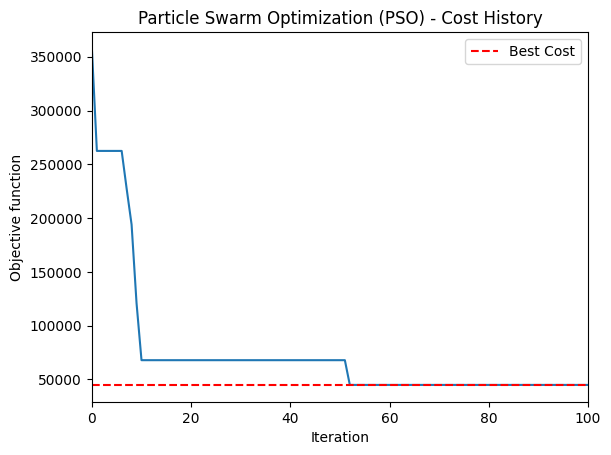

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 44844.04954552346
Tempo de Convergência para a segunda etapa: 1.4593229293823242 segundos


In [ ]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 1.000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

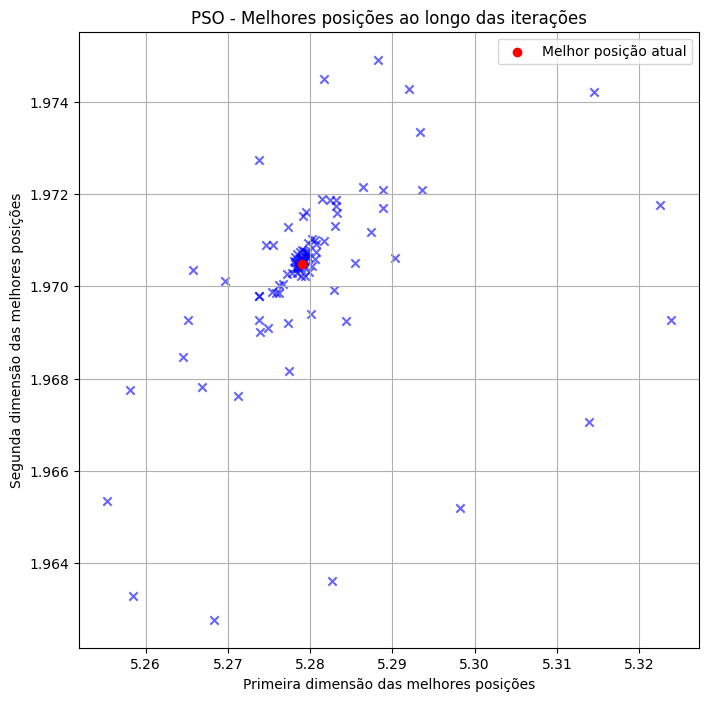

In [ ]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [ ]:
# # Nome do arquivo CSV para salvar o resultado do melhor custo
# nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [115]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv', sep=",")
resultado.head()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196,12
1,2,1.113853e+08,122.786813,9.995324,0.286275,0.005789,1.427013,8
2,3,1.059578e+08,124.352022,9.998797,0.309419,0.007851,1.646344,9
3,4,4.224613e+07,122.765793,9.998811,0.363530,0.011067,1.599882,8
4,5,1.013309e+08,120.763712,9.993543,0.417036,0.022115,1.480646,14


In [116]:
resultado.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,1.473235e+08,123.205073,9.993446,0.312531,0.011179,1.469604,9.000000
std,3.02765,1.071680e+08,1.701466,0.006043,0.077950,0.004829,0.108092,2.538591
min,1.00000,4.224613e+07,120.713917,9.980213,0.197210,0.005789,1.301908,5.000000
25%,3.25000,1.024876e+08,122.638986,9.991739,0.279276,0.008451,1.415772,8.000000
50%,5.50000,1.097181e+08,123.040587,9.995638,0.298754,0.009683,1.466480,8.500000
75%,7.75000,1.566829e+08,124.170901,9.997644,0.358638,0.011629,1.533150,9.750000
max,10.00000,4.221348e+08,126.031231,9.998811,0.431321,0.022115,1.646344,14.000000


In [117]:
colunas = ['Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

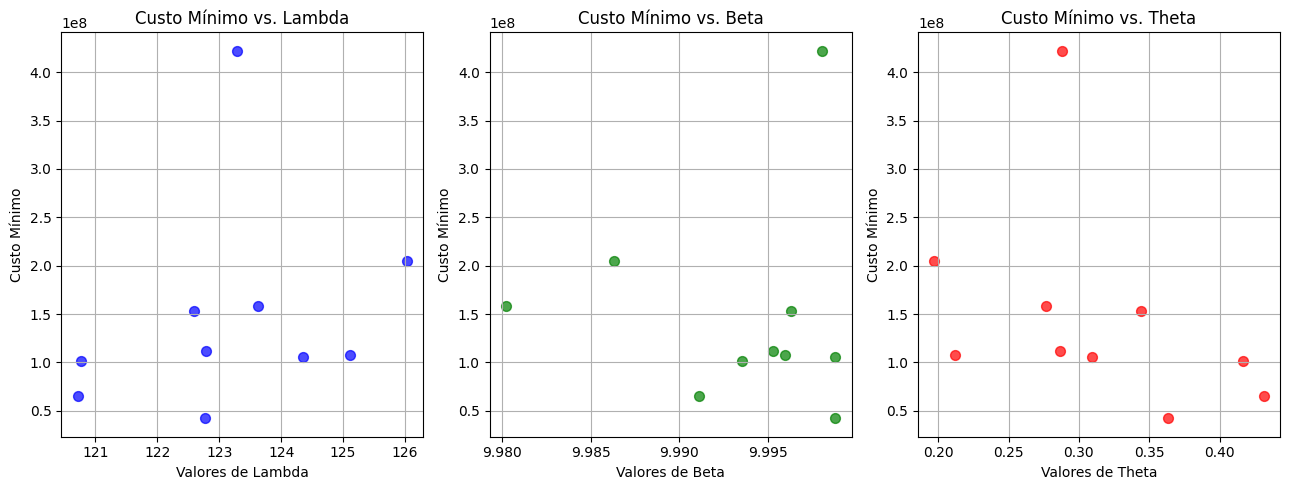

In [118]:
# Cria uma figura com três subgráficos da relação entre os os parametros Lambda, Beta e Theta com o melhor custo

fig, axes = plt.subplots(1, 3, figsize=(13, 5))

resultado.plot(kind='scatter', x='Lambda', y='Melhor_Custo', s=50, alpha=0.7, color='b', ax=axes[0])
axes[0].set_xlabel('Valores de Lambda')
axes[0].set_ylabel('Custo Mínimo')
axes[0].set_title('Custo Mínimo vs. Lambda')
axes[0].grid(True)

resultado.plot(kind='scatter', x='Beta', y='Melhor_Custo', s=50, alpha=0.7, color='g', ax=axes[1])
axes[1].set_xlabel('Valores de Beta')
axes[1].set_ylabel('Custo Mínimo')
axes[1].set_title('Custo Mínimo vs. Beta')
axes[1].grid(True)

resultado.plot(kind='scatter', x='Theta', y='Melhor_Custo', s=50, alpha=0.7, color='r', ax=axes[2])
axes[2].set_xlabel('Valores de Theta')
axes[2].set_ylabel('Custo Mínimo')
axes[2].set_title('Custo Mínimo vs. Theta')
axes[2].grid(True)

# Ajusta os espaçamentos entre subgráficos
plt.tight_layout()
plt.show()

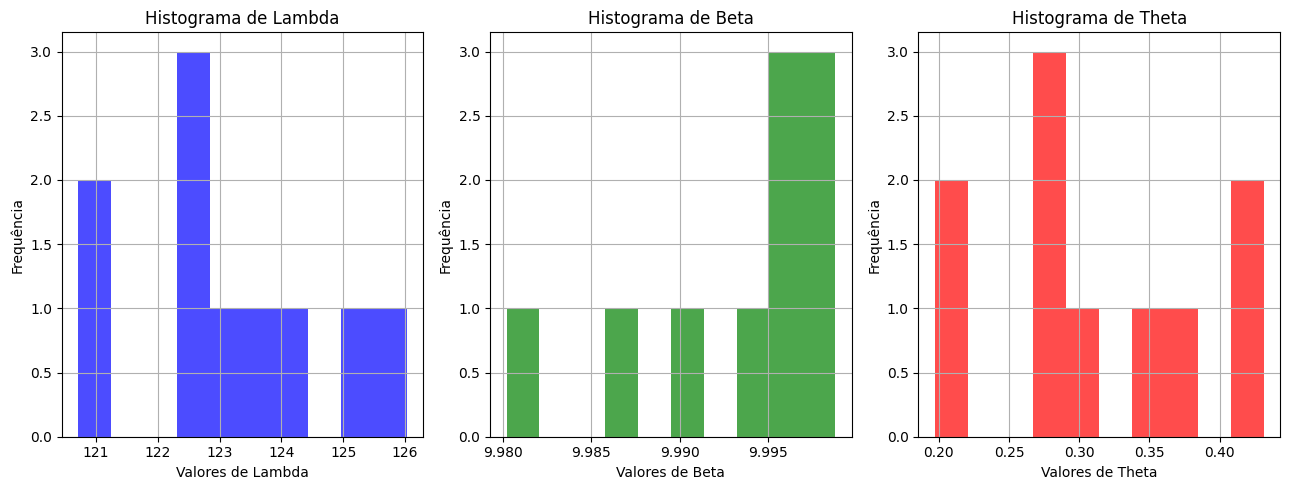

In [119]:
# Cria uma figura com três subgráficos da relação entre os os parametros Lambda, Beta e Theta com o melhor custo

fig, axs = plt.subplots(1, 3, figsize=(13, 5))

# Histograma para Lambda
axs[0].hist(resultado['Lambda'], bins=10, color='b', alpha=0.7)
axs[0].set_xlabel('Valores de Lambda')
axs[0].set_ylabel('Frequência')
axs[0].set_title('Histograma de Lambda')
axs[0].grid(True)

# Histograma para Beta
axs[1].hist(resultado['Beta'], bins=10, color='g', alpha=0.7)
axs[1].set_xlabel('Valores de Beta')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Histograma de Beta')
axs[1].grid(True)

# Histograma para Theta
axs[2].hist(resultado['Theta'], bins=10, color='r', alpha=0.7)
axs[2].set_xlabel('Valores de Theta')
axs[2].set_ylabel('Frequência')
axs[2].set_title('Histograma de Theta')
axs[2].grid(True)

# Ajusta os espaçamentos entre subgráficos
plt.tight_layout()
plt.show()

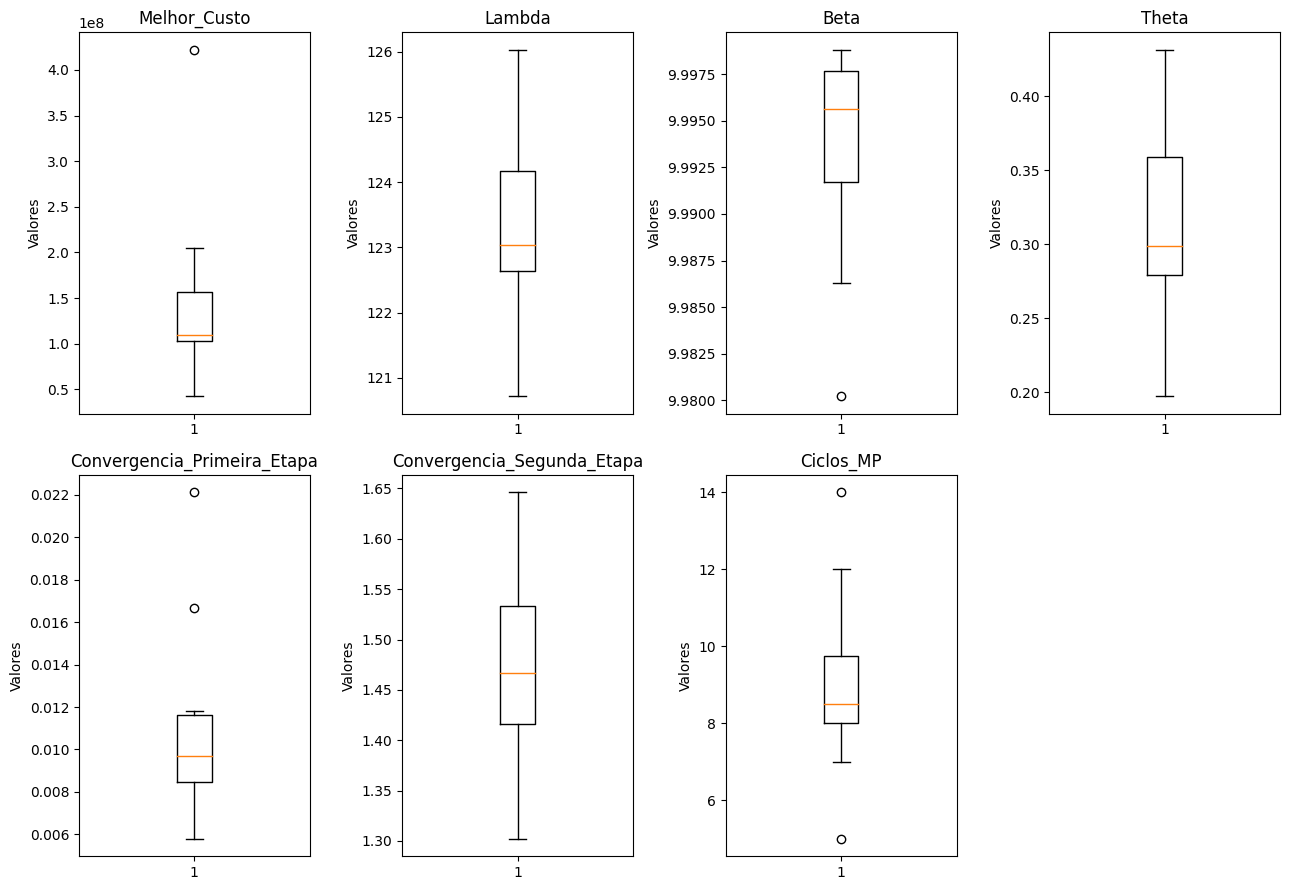

In [110]:
# Tamanho da figura
plt.figure(figsize=(13, 9))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(colunas):
    plt.subplot(2, 4, i + 1)  # 2 linhas, 4 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

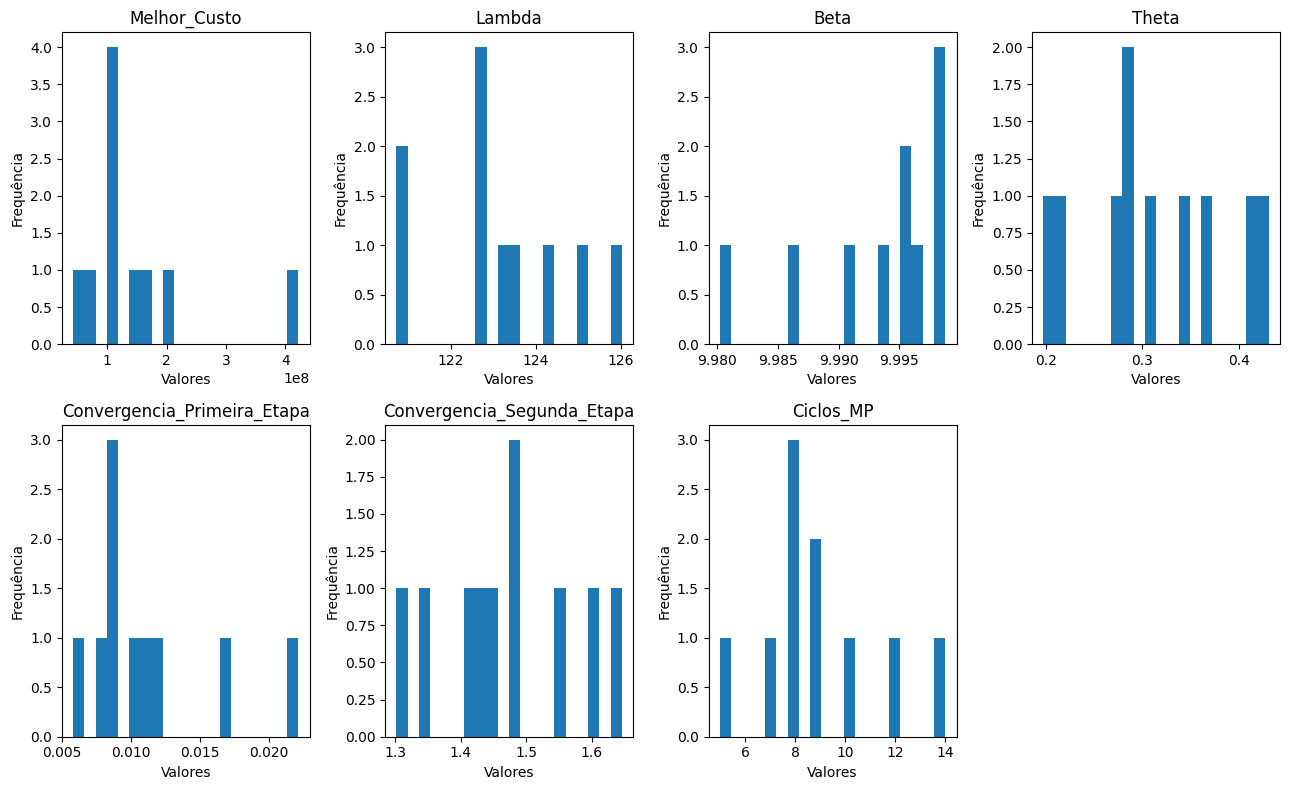

In [121]:
# Tamanho da figura
plt.figure(figsize=(13, 8))

# Itera sobre as colunas e cria um histograma para cada uma
for i, coluna in enumerate(colunas):
    plt.subplot(2, 4, i + 1)  # 2 linhas, 4 colunas de gráficos
    plt.hist(resultado[coluna], bins=20)  # Você pode ajustar o número de bins conforme necessário
    plt.title(coluna)
    plt.xlabel('Valores')
    plt.ylabel('Frequência')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [ ]:
# Arrays de tempos e severidade
Tempos = [
    [[0, 75, 102, 131, 174, 238, 343, 384, 433, 490, 523, 560, 575]],
    [[0, 198, 236, 325, 330, 370, 402, 488, 518]],
    [[0, 83, 150, 188, 257, 311, 330, 385, 463, 582]],
    [[0, 5, 42, 68, 186, 215, 305, 365, 504]],
    [[0, 22, 33, 60, 104, 134, 162, 245, 325, 334, 404, 462, 500, 512, 612]],
    [[0, 10, 112, 294, 311, 663]],
    [[0, 47, 83, 137, 156, 226, 395, 637]],
    [[0, 29, 49, 97, 144, 157, 276, 318, 393, 504, 556]],
    [[0, 11, 202, 225, 261, 292, 302, 382, 504, 545]],
    [[0, 14, 62, 205, 215, 313, 340, 423, 551]],
]

severidade = [
    [[0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5]],
    [[0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25]],
    [[0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]],
    [[0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]],
    [[0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5]],
    [[0.75, 0.75, 0.75, 0.75, 0.5]],
    [[0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25]],
    [[0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75]],
    [[0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]],
    [[0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenariociclo_tempo_severidade.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")


In [ ]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenariociclo_tempo_severidade.csv', sep=";")
dados.head()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,"[0, 75, 102, 131, 174, 238, 343, 384, 433, 490...","[0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0...."
1,"[0, 198, 236, 325, 330, 370, 402, 488, 518]","[0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25]"
2,"[0, 83, 150, 188, 257, 311, 330, 385, 463, 582]","[0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, ..."
3,"[0, 5, 42, 68, 186, 215, 305, 365, 504]","[0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]"
4,"[0, 22, 33, 60, 104, 134, 162, 245, 325, 334, ...","[0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0..."
